In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

%matplotlib inline

In [2]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print "dimension de las imagenes y las clases", X.shape, y.shape

dimension de las imagenes y las clases (1500, 784) (1500,)


In [3]:
X_train, X_test, y_train, y_test = X[:300], X[300:], y[:300], y[300:]
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print X_train.shape, y_train_oh.shape,  X_test.shape, y_test_oh.shape

(300, 784) (300, 10) (1200, 784) (1200, 10)


## Network architectures lab


from the notes we have two architectures:
    
- **A**: Three layer network accepting a 784 element vector as input and outputing a 10-class vector
- **B**: Same as **A** but accepts an additional 2 element vector with _evenness_ information that is injected at the third layer.

This lab requires you to do two things:

**1**. Create a **C** architecture similar to **B** but where the 2 element vector is injected at the second layer. This will make the network have 41,650 parameters, distributed in the following way:
   
   

        INPUT 1 to LAYER 1:              784*50 + 50 (bias) = 39250
        LAYER 1 to LAYER 2:               50*30 + 30 (bias) = 1530
        LAYER 2 + INPUT 2 to LAYER 3: (30+2)*20 + 20 (bias) = 660
        LAYER 3 to OUTPUT:                20*10 + 10 (bias) = 210
    
                                                       TOTAL 41650
                                                       
**2**. Run an experimental setup where you train different network configurations and measure the accuracy on test data. Fix the number of neurons to 50, 30 and 20 for each layer and the following combination of parameters:

- For architecture **A** (3 configurations)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`

- For architectures **B** and **C** (15 configurations for each architecture)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`
    
    `k1,k2` $\in$ `[(0,1), (-.5,2),(-.5,30), (0,15),(0,30)]`

And create a heat map showing the accuracy in test obtained for each configuration, such as the following (your results should be approximate to this):

![alt text](./Images/mm_results_1.png)


And two bar plots with the average per architecture and k1,k2 configuration, such as the following (again, your results should be approximetely similar):

![alt text](./Images/mm_results_2.png)

### Model definitions

In [4]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session

In [5]:
def get_model_A(input_dim, s1, s2, s3, s3_activation="relu"):
    clear_session()
    model = Sequential()
    model = Sequential()
    model.add(Dense(s1, activation='relu', input_dim=input_dim))
    model.add(Dense(s2, activation='relu'))
    model.add(Dense(s3, activation=s3_activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [6]:
def get_model_B(input_dim, extra_info_dim,  s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp1 = Input(shape=(input_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    l13 = Dense(s3, activation=s3_activation)(l12)
    
    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l13, inp2],axis=1) # Merge row, same column
    output = Dense(10, activation='softmax')(cc1)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [7]:
def get_model_C(input_dim, extra_info_dim, s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp2 = Input(shape=(extra_info_dim,))
    inp1 = Input(shape=(input_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    cc1 = concatenate([l12, inp2],axis=1) # Merge row, same column
    l13 = Dense(s3, activation=s3_activation)(l12)
    

    output = Dense(10, activation='softmax')(cc1)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [8]:
def get_X_extra(y_train, y_test, k0, k1):
    X_train_extra = (np.eye(2)[y_train%2]+k0)*k1
    X_test_extra  = (np.eye(2)[y_test%2]+k0)*k1
    return X_train_extra, X_test_extra

### Use the following dataframe to record your data 

In [9]:
k_set     = [(0,1), (-.5,2),(-.5,30), (0,15),(0,30), None]
act_set   = ["linear", "relu", "tanh"]
arch_set  = ["A", "B", "C"]


r_test = pd.DataFrame(np.zeros((len(arch_set)*len(act_set), len(k_set)))*np.nan, 
                      index=[[a+"-"+b for a,b in itertools.product (arch_set, act_set)]],
                      columns=[str(i) for i in k_set])
r_test

,"(0, 1)","(-0.5, 2)","(-0.5, 30)","(0, 15)","(0, 30)",None
A-linear,NaN,NaN,NaN,NaN,NaN,NaN
A-relu,NaN,NaN,NaN,NaN,NaN,NaN
A-tanh,NaN,NaN,NaN,NaN,NaN,NaN
B-linear,NaN,NaN,NaN,NaN,NaN,NaN
B-relu,NaN,NaN,NaN,NaN,NaN,NaN
B-tanh,NaN,NaN,NaN,NaN,NaN,NaN
C-linear,NaN,NaN,NaN,NaN,NaN,NaN
C-relu,NaN,NaN,NaN,NaN,NaN,NaN
C-tanh,NaN,NaN,NaN,NaN,NaN,NaN


### Build a loop over the configurations

In [10]:
for k, act, arch in itertools.product(k_set, act_set, arch_set):
    
    print "%10s %8s %1s"%(str(k), act, arch)    
    
    if arch == 'A':
        model = get_model_A(input_dim=X.shape[1], s1=50, s2=30, s3=20,s3_activation=act)
        model.fit(X_train, y_train_oh, epochs=200, batch_size=32, validation_data=(X_test, y_test_oh)) 
        preds_test = model.predict(X_test).argmax(axis=1)    
      
    if arch == 'B':
        X_train_extra, X_test_extra = get_X_extra(y_train, y_test, k0=k[0], k1=k[1])
        model = get_model_B(input_dim=X.shape[1], extra_info_dim=X_train_extra.shape[1], s1=50, s2=30, s3=20, s3_activation=act)
        model.fit([X_train, X_train_extra], y_train_oh, epochs=200, batch_size=100, validation_data=([X_test, X_test_extra], y_test_oh))
        preds_test = model.predict([X_test, X_test_extra]).argmax(axis=1)
        
   
    if arch=='C' and k!=None:
        X_train_extra, X_test_extra = get_X_extra(y_train, y_test, k0=k[0], k1=k[1])
        model = get_model_C(input_dim=X.shape[1], extra_info_dim=X_train_extra.shape[1], s1=50, s2=30, s3=20, s3_activation=act)
        model.fit([X_train, X_train_extra], y_train_oh, epochs=200, batch_size=32, validation_data=([X_test, X_test_extra], y_test_oh))
        preds_test = model.predict([X_test, X_test_extra]).argmax(axis=1)

    
   
    acc = np.mean(preds_test==y_test)
    model_act = arch+"-"+act
    r_test.set_value(model_act, str(k), acc)   


    (0, 1)   linear A
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 4ms/step - loss: 2.2243 - val_loss: 2.0683
Epoch 2/200
300/300 [==============================] - 0s 344us/step - loss: 1.8965 - val_loss: 1.8117
Epoch 3/200
300/300 [==============================] - 0s 313us/step - loss: 1.5712 - val_loss: 1.5389
Epoch 4/200
300/300 [==============================] - 0s 483us/step - loss: 1.2547 - val_loss: 1.2924
Epoch 5/200
300/300 [==============================] - 0s 434us/step - loss: 0.9940 - val_loss: 1.1046
Epoch 6/200
300/300 [==============================] - 0s 438us/step - loss: 0.7794 - val_loss: 0.9543
Epoch 7/200
300/300 [==============================] - 0s 527us/step - loss: 0.6181 - val_loss: 0.8621
Epoch 8/200
300/300 [==============================] - 0s 400us/step - loss: 0.4969 - val_loss: 0.8024
Epoch 9/200
300/300 [==============================] - 0s 326us/step - loss: 0.4038 - val_loss: 0.7495
Epoch 

300/300 [==============================] - 0s 373us/step - loss: 0.0020 - val_loss: 0.8997
Epoch 80/200
300/300 [==============================] - 0s 474us/step - loss: 0.0019 - val_loss: 0.9035
Epoch 81/200
300/300 [==============================] - 0s 406us/step - loss: 0.0019 - val_loss: 0.9043
Epoch 82/200
300/300 [==============================] - 0s 388us/step - loss: 0.0018 - val_loss: 0.9045
Epoch 83/200
300/300 [==============================] - 0s 374us/step - loss: 0.0018 - val_loss: 0.9083
Epoch 84/200
300/300 [==============================] - 0s 424us/step - loss: 0.0017 - val_loss: 0.9083
Epoch 85/200
300/300 [==============================] - 0s 428us/step - loss: 0.0017 - val_loss: 0.9116
Epoch 86/200
300/300 [==============================] - 0s 439us/step - loss: 0.0016 - val_loss: 0.9117
Epoch 87/200
300/300 [==============================] - 0s 480us/step - loss: 0.0016 - val_loss: 0.9135
Epoch 88/200
300/300 [==============================] - 0s 307us/step - loss:

300/300 [==============================] - 0s 265us/step - loss: 4.4849e-04 - val_loss: 1.0065
Epoch 156/200
300/300 [==============================] - 0s 269us/step - loss: 4.4305e-04 - val_loss: 1.0078
Epoch 157/200
300/300 [==============================] - 0s 262us/step - loss: 4.3594e-04 - val_loss: 1.0099
Epoch 158/200
300/300 [==============================] - 0s 271us/step - loss: 4.2926e-04 - val_loss: 1.0106
Epoch 159/200
300/300 [==============================] - 0s 265us/step - loss: 4.2330e-04 - val_loss: 1.0119
Epoch 160/200
300/300 [==============================] - 0s 256us/step - loss: 4.1791e-04 - val_loss: 1.0123
Epoch 161/200
300/300 [==============================] - 0s 262us/step - loss: 4.1230e-04 - val_loss: 1.0136
Epoch 162/200
300/300 [==============================] - 0s 264us/step - loss: 4.0573e-04 - val_loss: 1.0141
Epoch 163/200
300/300 [==============================] - 0s 267us/step - loss: 3.9991e-04 - val_loss: 1.0148
Epoch 164/200
300/300 [==========

/opt/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 2ms/step - loss: 2.2376 - val_loss: 2.1503
Epoch 2/200
300/300 [==============================] - 0s 155us/step - loss: 2.0812 - val_loss: 2.0449
Epoch 3/200
300/300 [==============================] - 0s 142us/step - loss: 1.9432 - val_loss: 1.9378
Epoch 4/200
300/300 [==============================] - 0s 141us/step - loss: 1.8000 - val_loss: 1.8215
Epoch 5/200
300/300 [==============================] - 0s 137us/step - loss: 1.6557 - val_loss: 1.6970
Epoch 6/200
300/300 [==============================] - 0s 155us/step - loss: 1.5151 - val_loss: 1.5787
Epoch 7/200
300/300 [==============================] - 0s 161us/step - loss: 1.3769 - val_loss: 1.4702
Epoch 8/200
300/300 [==============================] - 0s 190us/step - loss: 1.2445 - val_loss: 1.3680
Epoch 9/200
300/300 [==============================] - 0s 200us/step - loss: 1.1231 - val_loss: 1.2709
Epoch 10/200
300/300 [======

Epoch 79/200
300/300 [==============================] - 0s 274us/step - loss: 0.0064 - val_loss: 0.7516
Epoch 80/200
300/300 [==============================] - 0s 320us/step - loss: 0.0062 - val_loss: 0.7536
Epoch 81/200
300/300 [==============================] - 0s 283us/step - loss: 0.0061 - val_loss: 0.7553
Epoch 82/200
300/300 [==============================] - 0s 303us/step - loss: 0.0059 - val_loss: 0.7568
Epoch 83/200
300/300 [==============================] - 0s 287us/step - loss: 0.0057 - val_loss: 0.7595
Epoch 84/200
300/300 [==============================] - 0s 309us/step - loss: 0.0056 - val_loss: 0.7613
Epoch 85/200
300/300 [==============================] - 0s 282us/step - loss: 0.0054 - val_loss: 0.7632
Epoch 86/200
300/300 [==============================] - 0s 287us/step - loss: 0.0053 - val_loss: 0.7638
Epoch 87/200
300/300 [==============================] - 0s 306us/step - loss: 0.0051 - val_loss: 0.7655
Epoch 88/200
300/300 [==============================] - 0s 284us

Epoch 157/200
300/300 [==============================] - 0s 138us/step - loss: 0.0014 - val_loss: 0.8583
Epoch 158/200
300/300 [==============================] - ETA: 0s - loss: 0.001 - 0s 144us/step - loss: 0.0014 - val_loss: 0.8592
Epoch 159/200
300/300 [==============================] - 0s 148us/step - loss: 0.0014 - val_loss: 0.8598
Epoch 160/200
300/300 [==============================] - 0s 259us/step - loss: 0.0014 - val_loss: 0.8611
Epoch 161/200
300/300 [==============================] - 0s 149us/step - loss: 0.0014 - val_loss: 0.8624
Epoch 162/200
300/300 [==============================] - 0s 270us/step - loss: 0.0013 - val_loss: 0.8636
Epoch 163/200
300/300 [==============================] - 0s 352us/step - loss: 0.0013 - val_loss: 0.8648
Epoch 164/200
300/300 [==============================] - 0s 305us/step - loss: 0.0013 - val_loss: 0.8657
Epoch 165/200
300/300 [==============================] - 0s 284us/step - loss: 0.0013 - val_loss: 0.8662
Epoch 166/200
300/300 [========

300/300 [==============================] - 0s 1ms/step - loss: 0.0192 - val_loss: 0.6640
Epoch 35/200
300/300 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.6693
Epoch 36/200
300/300 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.6763
Epoch 37/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0158 - val_loss: 0.6739
Epoch 38/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.6767
Epoch 39/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.6790
Epoch 40/200
300/300 [==============================] - 0s 974us/step - loss: 0.0132 - val_loss: 0.6855
Epoch 41/200
300/300 [==============================] - 0s 818us/step - loss: 0.0125 - val_loss: 0.6855
Epoch 42/200
300/300 [==============================] - 0s 780us/step - loss: 0.0119 - val_loss: 0.6834
Epoch 43/200
300/300 [==============================] - 0s 933us/step - loss: 0.0112 - va

300/300 [==============================] - 0s 575us/step - loss: 0.0014 - val_loss: 0.8280
Epoch 114/200
300/300 [==============================] - 0s 797us/step - loss: 0.0013 - val_loss: 0.8288
Epoch 115/200
300/300 [==============================] - 0s 546us/step - loss: 0.0013 - val_loss: 0.8330
Epoch 116/200
300/300 [==============================] - 0s 784us/step - loss: 0.0013 - val_loss: 0.8346
Epoch 117/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.8363
Epoch 118/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.8376
Epoch 119/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.8388
Epoch 120/200
300/300 [==============================] - 0s 970us/step - loss: 0.0012 - val_loss: 0.8389
Epoch 121/200
300/300 [==============================] - 0s 778us/step - loss: 0.0012 - val_loss: 0.8404
Epoch 122/200
300/300 [==============================] - 0s 673us/step - lo

300/300 [==============================] - 0s 290us/step - loss: 4.3995e-04 - val_loss: 0.9122
Epoch 190/200
300/300 [==============================] - 0s 288us/step - loss: 4.3461e-04 - val_loss: 0.9139
Epoch 191/200
300/300 [==============================] - 0s 268us/step - loss: 4.2984e-04 - val_loss: 0.9151
Epoch 192/200
300/300 [==============================] - 0s 287us/step - loss: 4.2503e-04 - val_loss: 0.9177
Epoch 193/200
300/300 [==============================] - 0s 307us/step - loss: 4.1899e-04 - val_loss: 0.9185
Epoch 194/200
300/300 [==============================] - 0s 378us/step - loss: 4.1354e-04 - val_loss: 0.9167
Epoch 195/200
300/300 [==============================] - 0s 332us/step - loss: 4.0942e-04 - val_loss: 0.9167
Epoch 196/200
300/300 [==============================] - 0s 271us/step - loss: 4.0505e-04 - val_loss: 0.9174
Epoch 197/200
300/300 [==============================] - 0s 355us/step - loss: 3.9995e-04 - val_loss: 0.9190
Epoch 198/200
300/300 [==========

300/300 [==============================] - 0s 272us/step - loss: 0.0023 - val_loss: 0.8594
Epoch 67/200
300/300 [==============================] - 0s 279us/step - loss: 0.0022 - val_loss: 0.8570
Epoch 68/200
300/300 [==============================] - 0s 280us/step - loss: 0.0021 - val_loss: 0.8598
Epoch 69/200
300/300 [==============================] - 0s 290us/step - loss: 0.0021 - val_loss: 0.8600
Epoch 70/200
300/300 [==============================] - 0s 279us/step - loss: 0.0020 - val_loss: 0.8627
Epoch 71/200
300/300 [==============================] - 0s 277us/step - loss: 0.0019 - val_loss: 0.8630
Epoch 72/200
300/300 [==============================] - 0s 275us/step - loss: 0.0019 - val_loss: 0.8641
Epoch 73/200
300/300 [==============================] - 0s 279us/step - loss: 0.0018 - val_loss: 0.8719
Epoch 74/200
300/300 [==============================] - 0s 290us/step - loss: 0.0018 - val_loss: 0.8744
Epoch 75/200
300/300 [==============================] - 0s 278us/step - loss:

300/300 [==============================] - 0s 379us/step - loss: 3.9019e-04 - val_loss: 0.9665
Epoch 143/200
300/300 [==============================] - 0s 709us/step - loss: 3.8396e-04 - val_loss: 0.9686
Epoch 144/200
300/300 [==============================] - 0s 346us/step - loss: 3.7788e-04 - val_loss: 0.9678
Epoch 145/200
300/300 [==============================] - 0s 300us/step - loss: 3.7171e-04 - val_loss: 0.9682
Epoch 146/200
300/300 [==============================] - ETA: 0s - loss: 3.4791e-0 - 0s 319us/step - loss: 3.6636e-04 - val_loss: 0.9723
Epoch 147/200
300/300 [==============================] - 0s 556us/step - loss: 3.6012e-04 - val_loss: 0.9718
Epoch 148/200
300/300 [==============================] - 0s 634us/step - loss: 3.5450e-04 - val_loss: 0.9749
Epoch 149/200
300/300 [==============================] - 0s 643us/step - loss: 3.4873e-04 - val_loss: 0.9761
Epoch 150/200
300/300 [==============================] - 0s 813us/step - loss: 3.4351e-04 - val_loss: 0.9782
Epoch

300/300 [==============================] - 0s 146us/step - loss: 0.7180 - val_loss: 1.0322
Epoch 18/200
300/300 [==============================] - 0s 141us/step - loss: 0.6442 - val_loss: 0.9820
Epoch 19/200
300/300 [==============================] - 0s 154us/step - loss: 0.5766 - val_loss: 0.9486
Epoch 20/200
300/300 [==============================] - 0s 147us/step - loss: 0.5179 - val_loss: 0.9061
Epoch 21/200
300/300 [==============================] - 0s 141us/step - loss: 0.4615 - val_loss: 0.8754
Epoch 22/200
300/300 [==============================] - 0s 137us/step - loss: 0.4134 - val_loss: 0.8477
Epoch 23/200
300/300 [==============================] - 0s 165us/step - loss: 0.3697 - val_loss: 0.8227
Epoch 24/200
300/300 [==============================] - 0s 180us/step - loss: 0.3300 - val_loss: 0.8038
Epoch 25/200
300/300 [==============================] - 0s 175us/step - loss: 0.2936 - val_loss: 0.7996
Epoch 26/200
300/300 [==============================] - 0s 162us/step - loss:

Epoch 96/200
300/300 [==============================] - 0s 153us/step - loss: 0.0050 - val_loss: 0.9121
Epoch 97/200
300/300 [==============================] - 0s 148us/step - loss: 0.0048 - val_loss: 0.9131
Epoch 98/200
300/300 [==============================] - ETA: 0s - loss: 0.005 - 0s 160us/step - loss: 0.0047 - val_loss: 0.9150
Epoch 99/200
300/300 [==============================] - 0s 153us/step - loss: 0.0046 - val_loss: 0.9173
Epoch 100/200
300/300 [==============================] - 0s 153us/step - loss: 0.0045 - val_loss: 0.9209
Epoch 101/200
300/300 [==============================] - 0s 140us/step - loss: 0.0044 - val_loss: 0.9208
Epoch 102/200
300/300 [==============================] - 0s 151us/step - loss: 0.0043 - val_loss: 0.9236
Epoch 103/200
300/300 [==============================] - 0s 159us/step - loss: 0.0042 - val_loss: 0.9252
Epoch 104/200
300/300 [==============================] - 0s 144us/step - loss: 0.0041 - val_loss: 0.9284
Epoch 105/200
300/300 [============

300/300 [==============================] - 0s 156us/step - loss: 0.0013 - val_loss: 1.0290
Epoch 174/200
300/300 [==============================] - 0s 167us/step - loss: 0.0013 - val_loss: 1.0305
Epoch 175/200
300/300 [==============================] - 0s 209us/step - loss: 0.0013 - val_loss: 1.0314
Epoch 176/200
300/300 [==============================] - 0s 348us/step - loss: 0.0013 - val_loss: 1.0330
Epoch 177/200
300/300 [==============================] - 0s 273us/step - loss: 0.0013 - val_loss: 1.0344
Epoch 178/200
300/300 [==============================] - 0s 185us/step - loss: 0.0013 - val_loss: 1.0347
Epoch 179/200
300/300 [==============================] - 0s 168us/step - loss: 0.0013 - val_loss: 1.0357
Epoch 180/200
300/300 [==============================] - 0s 157us/step - loss: 0.0012 - val_loss: 1.0366
Epoch 181/200
300/300 [==============================] - 0s 150us/step - loss: 0.0012 - val_loss: 1.0383
Epoch 182/200
300/300 [==============================] - 0s 147us/ste

300/300 [==============================] - 0s 272us/step - loss: 0.0078 - val_loss: 0.7201
Epoch 52/200
300/300 [==============================] - 0s 292us/step - loss: 0.0074 - val_loss: 0.7162
Epoch 53/200
300/300 [==============================] - 0s 266us/step - loss: 0.0071 - val_loss: 0.7174
Epoch 54/200
300/300 [==============================] - 0s 268us/step - loss: 0.0068 - val_loss: 0.7257
Epoch 55/200
300/300 [==============================] - 0s 274us/step - loss: 0.0065 - val_loss: 0.7301
Epoch 56/200
300/300 [==============================] - 0s 279us/step - loss: 0.0062 - val_loss: 0.7337
Epoch 57/200
300/300 [==============================] - 0s 268us/step - loss: 0.0060 - val_loss: 0.7298
Epoch 58/200
300/300 [==============================] - 0s 287us/step - loss: 0.0057 - val_loss: 0.7406
Epoch 59/200
300/300 [==============================] - 0s 266us/step - loss: 0.0055 - val_loss: 0.7403
Epoch 60/200
300/300 [==============================] - 0s 271us/step - loss:

300/300 [==============================] - 0s 270us/step - loss: 8.8873e-04 - val_loss: 0.8711
Epoch 130/200
300/300 [==============================] - 0s 269us/step - loss: 8.7305e-04 - val_loss: 0.8709
Epoch 131/200
300/300 [==============================] - 0s 279us/step - loss: 8.5666e-04 - val_loss: 0.8726
Epoch 132/200
300/300 [==============================] - 0s 288us/step - loss: 8.4266e-04 - val_loss: 0.8739
Epoch 133/200
300/300 [==============================] - 0s 268us/step - loss: 8.2850e-04 - val_loss: 0.8742
Epoch 134/200
300/300 [==============================] - 0s 260us/step - loss: 8.1429e-04 - val_loss: 0.8747
Epoch 135/200
300/300 [==============================] - 0s 278us/step - loss: 8.0110e-04 - val_loss: 0.8775
Epoch 136/200
300/300 [==============================] - 0s 265us/step - loss: 7.8686e-04 - val_loss: 0.8806
Epoch 137/200
300/300 [==============================] - 0s 275us/step - loss: 7.7485e-04 - val_loss: 0.8828
Epoch 138/200
300/300 [==========

Epoch 4/200
300/300 [==============================] - 0s 272us/step - loss: 1.4549 - val_loss: 1.5136
Epoch 5/200
300/300 [==============================] - 0s 266us/step - loss: 1.2528 - val_loss: 1.3543
Epoch 6/200
300/300 [==============================] - 0s 281us/step - loss: 1.0786 - val_loss: 1.2180
Epoch 7/200
300/300 [==============================] - 0s 282us/step - loss: 0.9193 - val_loss: 1.0999
Epoch 8/200
300/300 [==============================] - 0s 294us/step - loss: 0.7724 - val_loss: 1.0037
Epoch 9/200
300/300 [==============================] - 0s 275us/step - loss: 0.6614 - val_loss: 0.9268
Epoch 10/200
300/300 [==============================] - 0s 306us/step - loss: 0.5643 - val_loss: 0.8613
Epoch 11/200
300/300 [==============================] - 0s 291us/step - loss: 0.4806 - val_loss: 0.8190
Epoch 12/200
300/300 [==============================] - 0s 276us/step - loss: 0.4186 - val_loss: 0.7814
Epoch 13/200
300/300 [==============================] - 0s 295us/step 

Epoch 83/200
300/300 [==============================] - 0s 287us/step - loss: 0.0108 - val_loss: 0.6625
Epoch 84/200
300/300 [==============================] - 0s 257us/step - loss: 0.0106 - val_loss: 0.6627
Epoch 85/200
300/300 [==============================] - 0s 281us/step - loss: 0.0104 - val_loss: 0.6648
Epoch 86/200
300/300 [==============================] - 0s 267us/step - loss: 0.0102 - val_loss: 0.6662
Epoch 87/200
300/300 [==============================] - 0s 281us/step - loss: 0.0100 - val_loss: 0.6643
Epoch 88/200
300/300 [==============================] - 0s 280us/step - loss: 0.0098 - val_loss: 0.6672
Epoch 89/200
300/300 [==============================] - 0s 275us/step - loss: 0.0096 - val_loss: 0.6683
Epoch 90/200
300/300 [==============================] - 0s 265us/step - loss: 0.0094 - val_loss: 0.6696
Epoch 91/200
300/300 [==============================] - 0s 286us/step - loss: 0.0092 - val_loss: 0.6695
Epoch 92/200
300/300 [==============================] - 0s 271us

300/300 [==============================] - 0s 297us/step - loss: 0.0034 - val_loss: 0.7248
Epoch 162/200
300/300 [==============================] - 0s 296us/step - loss: 0.0034 - val_loss: 0.7265
Epoch 163/200
300/300 [==============================] - 0s 288us/step - loss: 0.0033 - val_loss: 0.7277
Epoch 164/200
300/300 [==============================] - 0s 274us/step - loss: 0.0033 - val_loss: 0.7292
Epoch 165/200
300/300 [==============================] - 0s 287us/step - loss: 0.0032 - val_loss: 0.7294
Epoch 166/200
300/300 [==============================] - 0s 270us/step - loss: 0.0032 - val_loss: 0.7296
Epoch 167/200
300/300 [==============================] - 0s 302us/step - loss: 0.0032 - val_loss: 0.7320
Epoch 168/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.7325
Epoch 169/200
300/300 [==============================] - 0s 503us/step - loss: 0.0031 - val_loss: 0.7326
Epoch 170/200
300/300 [==============================] - 0s 496us/step 

Epoch 39/200
300/300 [==============================] - 0s 391us/step - loss: 0.1967 - val_loss: 0.7447
Epoch 40/200
300/300 [==============================] - 0s 244us/step - loss: 0.1874 - val_loss: 0.7361
Epoch 41/200
300/300 [==============================] - 0s 352us/step - loss: 0.1787 - val_loss: 0.7330
Epoch 42/200
300/300 [==============================] - 0s 338us/step - loss: 0.1704 - val_loss: 0.7337
Epoch 43/200
300/300 [==============================] - 0s 300us/step - loss: 0.1626 - val_loss: 0.7319
Epoch 44/200
300/300 [==============================] - 0s 228us/step - loss: 0.1557 - val_loss: 0.7286
Epoch 45/200
300/300 [==============================] - 0s 248us/step - loss: 0.1487 - val_loss: 0.7249
Epoch 46/200
300/300 [==============================] - 0s 230us/step - loss: 0.1425 - val_loss: 0.7235
Epoch 47/200
300/300 [==============================] - 0s 303us/step - loss: 0.1364 - val_loss: 0.7232
Epoch 48/200
300/300 [==============================] - 0s 449us

300/300 [==============================] - 0s 271us/step - loss: 0.0261 - val_loss: 0.7077
Epoch 118/200
300/300 [==============================] - 0s 211us/step - loss: 0.0257 - val_loss: 0.7072
Epoch 119/200
300/300 [==============================] - 0s 215us/step - loss: 0.0253 - val_loss: 0.7075
Epoch 120/200
300/300 [==============================] - 0s 181us/step - loss: 0.0249 - val_loss: 0.7085
Epoch 121/200
300/300 [==============================] - 0s 346us/step - loss: 0.0245 - val_loss: 0.7095
Epoch 122/200
300/300 [==============================] - 0s 266us/step - loss: 0.0242 - val_loss: 0.7091
Epoch 123/200
300/300 [==============================] - 0s 290us/step - loss: 0.0238 - val_loss: 0.7084
Epoch 124/200
300/300 [==============================] - 0s 233us/step - loss: 0.0235 - val_loss: 0.7079
Epoch 125/200
300/300 [==============================] - 0s 310us/step - loss: 0.0231 - val_loss: 0.7092
Epoch 126/200
300/300 [==============================] - 0s 206us/ste

Epoch 195/200
300/300 [==============================] - 0s 425us/step - loss: 0.0105 - val_loss: 0.7450
Epoch 196/200
300/300 [==============================] - 0s 323us/step - loss: 0.0104 - val_loss: 0.7454
Epoch 197/200
300/300 [==============================] - 0s 312us/step - loss: 0.0103 - val_loss: 0.7459
Epoch 198/200
300/300 [==============================] - 0s 357us/step - loss: 0.0102 - val_loss: 0.7465
Epoch 199/200
300/300 [==============================] - 0s 316us/step - loss: 0.0102 - val_loss: 0.7469
Epoch 200/200
300/300 [==============================] - 0s 256us/step - loss: 0.0101 - val_loss: 0.7472
    (0, 1)     tanh C
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 4ms/step - loss: 2.2214 - val_loss: 2.0980
Epoch 2/200
300/300 [==============================] - 0s 517us/step - loss: 1.8916 - val_loss: 1.8445
Epoch 3/200
300/300 [==============================] - 0s 437us/step - loss: 1.5783 - val_loss: 1

300/300 [==============================] - 0s 356us/step - loss: 0.0036 - val_loss: 0.7885
Epoch 74/200
300/300 [==============================] - 0s 377us/step - loss: 0.0035 - val_loss: 0.7899
Epoch 75/200
300/300 [==============================] - 0s 370us/step - loss: 0.0034 - val_loss: 0.7932
Epoch 76/200
300/300 [==============================] - 0s 351us/step - loss: 0.0033 - val_loss: 0.7952
Epoch 77/200
300/300 [==============================] - 0s 368us/step - loss: 0.0032 - val_loss: 0.7964
Epoch 78/200
300/300 [==============================] - 0s 360us/step - loss: 0.0031 - val_loss: 0.7973
Epoch 79/200
300/300 [==============================] - 0s 359us/step - loss: 0.0030 - val_loss: 0.8005
Epoch 80/200
300/300 [==============================] - 0s 341us/step - loss: 0.0029 - val_loss: 0.8053
Epoch 81/200
300/300 [==============================] - 0s 337us/step - loss: 0.0029 - val_loss: 0.8064
Epoch 82/200
300/300 [==============================] - 0s 374us/step - loss:

300/300 [==============================] - 0s 384us/step - loss: 7.3255e-04 - val_loss: 0.8978
Epoch 151/200
300/300 [==============================] - 0s 350us/step - loss: 7.2152e-04 - val_loss: 0.8976
Epoch 152/200
300/300 [==============================] - 0s 300us/step - loss: 7.1020e-04 - val_loss: 0.8998
Epoch 153/200
300/300 [==============================] - 0s 289us/step - loss: 6.9850e-04 - val_loss: 0.9003
Epoch 154/200
300/300 [==============================] - 0s 289us/step - loss: 6.8990e-04 - val_loss: 0.9005
Epoch 155/200
300/300 [==============================] - 0s 289us/step - loss: 6.7805e-04 - val_loss: 0.9024
Epoch 156/200
300/300 [==============================] - 0s 298us/step - loss: 6.6973e-04 - val_loss: 0.9033
Epoch 157/200
300/300 [==============================] - 0s 293us/step - loss: 6.5918e-04 - val_loss: 0.9034
Epoch 158/200
300/300 [==============================] - 0s 286us/step - loss: 6.5229e-04 - val_loss: 0.9069
Epoch 159/200
300/300 [==========

Epoch 26/200
300/300 [==============================] - 0s 283us/step - loss: 0.0215 - val_loss: 0.6305
Epoch 27/200
300/300 [==============================] - 0s 281us/step - loss: 0.0196 - val_loss: 0.6380
Epoch 28/200
300/300 [==============================] - 0s 273us/step - loss: 0.0178 - val_loss: 0.6387
Epoch 29/200
300/300 [==============================] - 0s 280us/step - loss: 0.0162 - val_loss: 0.6546
Epoch 30/200
300/300 [==============================] - 0s 278us/step - loss: 0.0148 - val_loss: 0.6471
Epoch 31/200
300/300 [==============================] - 0s 288us/step - loss: 0.0136 - val_loss: 0.6500
Epoch 32/200
300/300 [==============================] - 0s 281us/step - loss: 0.0123 - val_loss: 0.6535
Epoch 33/200
300/300 [==============================] - 0s 283us/step - loss: 0.0114 - val_loss: 0.6673
Epoch 34/200
300/300 [==============================] - 0s 289us/step - loss: 0.0106 - val_loss: 0.6675
Epoch 35/200
300/300 [==============================] - 0s 283us

Epoch 104/200
300/300 [==============================] - 0s 951us/step - loss: 7.0744e-04 - val_loss: 0.8350
Epoch 105/200
300/300 [==============================] - 0s 303us/step - loss: 6.9191e-04 - val_loss: 0.8364
Epoch 106/200
300/300 [==============================] - 0s 272us/step - loss: 6.7826e-04 - val_loss: 0.8386
Epoch 107/200
300/300 [==============================] - 0s 278us/step - loss: 6.6270e-04 - val_loss: 0.8404
Epoch 108/200
300/300 [==============================] - 0s 282us/step - loss: 6.4900e-04 - val_loss: 0.8425
Epoch 109/200
300/300 [==============================] - 0s 319us/step - loss: 6.3664e-04 - val_loss: 0.8462
Epoch 110/200
300/300 [==============================] - 0s 373us/step - loss: 6.2249e-04 - val_loss: 0.8458
Epoch 111/200
300/300 [==============================] - 0s 323us/step - loss: 6.0961e-04 - val_loss: 0.8461
Epoch 112/200
300/300 [==============================] - 0s 269us/step - loss: 5.9633e-04 - val_loss: 0.8474
Epoch 113/200
300/3

300/300 [==============================] - 0s 340us/step - loss: 1.9910e-04 - val_loss: 0.9276
Epoch 180/200
300/300 [==============================] - 0s 355us/step - loss: 1.9643e-04 - val_loss: 0.9284
Epoch 181/200
300/300 [==============================] - 0s 339us/step - loss: 1.9403e-04 - val_loss: 0.9279
Epoch 182/200
300/300 [==============================] - 0s 314us/step - loss: 1.9167e-04 - val_loss: 0.9308
Epoch 183/200
300/300 [==============================] - 0s 298us/step - loss: 1.8888e-04 - val_loss: 0.9321
Epoch 184/200
300/300 [==============================] - 0s 339us/step - loss: 1.8617e-04 - val_loss: 0.9325
Epoch 185/200
300/300 [==============================] - 0s 285us/step - loss: 1.8390e-04 - val_loss: 0.9332
Epoch 186/200
300/300 [==============================] - 0s 287us/step - loss: 1.8189e-04 - val_loss: 0.9339
Epoch 187/200
300/300 [==============================] - 0s 347us/step - loss: 1.7925e-04 - val_loss: 0.9351
Epoch 188/200
300/300 [==========

300/300 [==============================] - 0s 164us/step - loss: 0.0178 - val_loss: 0.7334
Epoch 57/200
300/300 [==============================] - 0s 229us/step - loss: 0.0170 - val_loss: 0.7374
Epoch 58/200
300/300 [==============================] - 0s 283us/step - loss: 0.0162 - val_loss: 0.7387
Epoch 59/200
300/300 [==============================] - 0s 280us/step - loss: 0.0155 - val_loss: 0.7419
Epoch 60/200
300/300 [==============================] - 0s 200us/step - loss: 0.0149 - val_loss: 0.7415
Epoch 61/200
300/300 [==============================] - 0s 177us/step - loss: 0.0142 - val_loss: 0.7440
Epoch 62/200
300/300 [==============================] - 0s 169us/step - loss: 0.0137 - val_loss: 0.7479
Epoch 63/200
300/300 [==============================] - 0s 158us/step - loss: 0.0131 - val_loss: 0.7516
Epoch 64/200
300/300 [==============================] - 0s 159us/step - loss: 0.0126 - val_loss: 0.7548
Epoch 65/200
300/300 [==============================] - 0s 160us/step - loss:

300/300 [==============================] - 0s 146us/step - loss: 0.0024 - val_loss: 0.8644
Epoch 135/200
300/300 [==============================] - 0s 148us/step - loss: 0.0023 - val_loss: 0.8658
Epoch 136/200
300/300 [==============================] - 0s 150us/step - loss: 0.0023 - val_loss: 0.8673
Epoch 137/200
300/300 [==============================] - 0s 155us/step - loss: 0.0023 - val_loss: 0.8691
Epoch 138/200
300/300 [==============================] - 0s 144us/step - loss: 0.0022 - val_loss: 0.8698
Epoch 139/200
300/300 [==============================] - 0s 163us/step - loss: 0.0022 - val_loss: 0.8710
Epoch 140/200
300/300 [==============================] - 0s 146us/step - loss: 0.0022 - val_loss: 0.8714
Epoch 141/200
300/300 [==============================] - 0s 154us/step - loss: 0.0021 - val_loss: 0.8727
Epoch 142/200
300/300 [==============================] - 0s 151us/step - loss: 0.0021 - val_loss: 0.8736
Epoch 143/200
300/300 [==============================] - 0s 161us/ste

300/300 [==============================] - 0s 316us/step - loss: 0.3228 - val_loss: 0.7400
Epoch 12/200
300/300 [==============================] - 0s 597us/step - loss: 0.2725 - val_loss: 0.7168
Epoch 13/200
300/300 [==============================] - 0s 689us/step - loss: 0.2326 - val_loss: 0.7089
Epoch 14/200
300/300 [==============================] - 0s 617us/step - loss: 0.2071 - val_loss: 0.7022
Epoch 15/200
300/300 [==============================] - 0s 858us/step - loss: 0.1691 - val_loss: 0.6611
Epoch 16/200
300/300 [==============================] - 0s 473us/step - loss: 0.1448 - val_loss: 0.6885
Epoch 17/200
300/300 [==============================] - 0s 442us/step - loss: 0.1224 - val_loss: 0.6610
Epoch 18/200
300/300 [==============================] - 0s 283us/step - loss: 0.1053 - val_loss: 0.6692
Epoch 19/200
300/300 [==============================] - 0s 314us/step - loss: 0.0931 - val_loss: 0.6788
Epoch 20/200
300/300 [==============================] - 0s 566us/step - loss:

Epoch 90/200
300/300 [==============================] - 0s 304us/step - loss: 0.0018 - val_loss: 0.8522
Epoch 91/200
300/300 [==============================] - 0s 276us/step - loss: 0.0018 - val_loss: 0.8523
Epoch 92/200
300/300 [==============================] - 0s 273us/step - loss: 0.0017 - val_loss: 0.8540
Epoch 93/200
300/300 [==============================] - 0s 290us/step - loss: 0.0017 - val_loss: 0.8588
Epoch 94/200
300/300 [==============================] - 0s 276us/step - loss: 0.0016 - val_loss: 0.8600
Epoch 95/200
300/300 [==============================] - 0s 294us/step - loss: 0.0016 - val_loss: 0.8602
Epoch 96/200
300/300 [==============================] - 0s 273us/step - loss: 0.0016 - val_loss: 0.8605
Epoch 97/200
300/300 [==============================] - 0s 274us/step - loss: 0.0015 - val_loss: 0.8648
Epoch 98/200
300/300 [==============================] - 0s 267us/step - loss: 0.0015 - val_loss: 0.8660
Epoch 99/200
300/300 [==============================] - 0s 270us

300/300 [==============================] - 0s 274us/step - loss: 4.4585e-04 - val_loss: 0.9498
Epoch 167/200
300/300 [==============================] - 0s 277us/step - loss: 4.4012e-04 - val_loss: 0.9509
Epoch 168/200
300/300 [==============================] - 0s 276us/step - loss: 4.3385e-04 - val_loss: 0.9521
Epoch 169/200
300/300 [==============================] - 0s 288us/step - loss: 4.2737e-04 - val_loss: 0.9527
Epoch 170/200
300/300 [==============================] - 0s 271us/step - loss: 4.2119e-04 - val_loss: 0.9550
Epoch 171/200
300/300 [==============================] - 0s 279us/step - loss: 4.1594e-04 - val_loss: 0.9568
Epoch 172/200
300/300 [==============================] - 0s 272us/step - loss: 4.1047e-04 - val_loss: 0.9582
Epoch 173/200
300/300 [==============================] - 0s 299us/step - loss: 4.0595e-04 - val_loss: 0.9590
Epoch 174/200
300/300 [==============================] - 0s 291us/step - loss: 4.0021e-04 - val_loss: 0.9589
Epoch 175/200
300/300 [==========

300/300 [==============================] - 0s 338us/step - loss: 0.0087 - val_loss: 0.7946
Epoch 43/200
300/300 [==============================] - 0s 357us/step - loss: 0.0082 - val_loss: 0.8028
Epoch 44/200
300/300 [==============================] - 0s 359us/step - loss: 0.0078 - val_loss: 0.8016
Epoch 45/200
300/300 [==============================] - 0s 346us/step - loss: 0.0074 - val_loss: 0.8059
Epoch 46/200
300/300 [==============================] - 0s 333us/step - loss: 0.0070 - val_loss: 0.8071
Epoch 47/200
300/300 [==============================] - 0s 322us/step - loss: 0.0066 - val_loss: 0.8115
Epoch 48/200
300/300 [==============================] - 0s 324us/step - loss: 0.0064 - val_loss: 0.8193
Epoch 49/200
300/300 [==============================] - 0s 348us/step - loss: 0.0060 - val_loss: 0.8175
Epoch 50/200
300/300 [==============================] - 0s 363us/step - loss: 0.0057 - val_loss: 0.8225
Epoch 51/200
300/300 [==============================] - 0s 346us/step - loss:

Epoch 120/200
300/300 [==============================] - 0s 304us/step - loss: 8.0576e-04 - val_loss: 0.9506
Epoch 121/200
300/300 [==============================] - 0s 345us/step - loss: 7.9098e-04 - val_loss: 0.9516
Epoch 122/200
300/300 [==============================] - 0s 299us/step - loss: 7.7650e-04 - val_loss: 0.9513
Epoch 123/200
300/300 [==============================] - 0s 312us/step - loss: 7.6374e-04 - val_loss: 0.9528
Epoch 124/200
300/300 [==============================] - 0s 310us/step - loss: 7.5109e-04 - val_loss: 0.9560
Epoch 125/200
300/300 [==============================] - 0s 312us/step - loss: 7.3489e-04 - val_loss: 0.9563
Epoch 126/200
300/300 [==============================] - 0s 326us/step - loss: 7.2337e-04 - val_loss: 0.9583
Epoch 127/200
300/300 [==============================] - 0s 318us/step - loss: 7.1029e-04 - val_loss: 0.9598
Epoch 128/200
300/300 [==============================] - 0s 306us/step - loss: 6.9850e-04 - val_loss: 0.9616
Epoch 129/200
300/3

Epoch 195/200
300/300 [==============================] - 0s 313us/step - loss: 2.6662e-04 - val_loss: 1.0317
Epoch 196/200
300/300 [==============================] - 0s 315us/step - loss: 2.6341e-04 - val_loss: 1.0326
Epoch 197/200
300/300 [==============================] - 0s 298us/step - loss: 2.6039e-04 - val_loss: 1.0321
Epoch 198/200
300/300 [==============================] - 0s 301us/step - loss: 2.5737e-04 - val_loss: 1.0324
Epoch 199/200
300/300 [==============================] - 0s 308us/step - loss: 2.5398e-04 - val_loss: 1.0337
Epoch 200/200
300/300 [==============================] - 0s 343us/step - loss: 2.5103e-04 - val_loss: 1.0347
 (-0.5, 2)     relu B
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 2ms/step - loss: 2.4019 - val_loss: 2.3456
Epoch 2/200
300/300 [==============================] - 0s 149us/step - loss: 2.2769 - val_loss: 2.2738
Epoch 3/200
300/300 [==============================] - 0s 153us/step - lo

Epoch 73/200
300/300 [==============================] - 0s 164us/step - loss: 0.0119 - val_loss: 0.7202
Epoch 74/200
300/300 [==============================] - 0s 182us/step - loss: 0.0115 - val_loss: 0.7201
Epoch 75/200
300/300 [==============================] - 0s 166us/step - loss: 0.0111 - val_loss: 0.7218
Epoch 76/200
300/300 [==============================] - 0s 172us/step - loss: 0.0107 - val_loss: 0.7230
Epoch 77/200
300/300 [==============================] - 0s 171us/step - loss: 0.0103 - val_loss: 0.7243
Epoch 78/200
300/300 [==============================] - 0s 167us/step - loss: 0.0100 - val_loss: 0.7261
Epoch 79/200
300/300 [==============================] - 0s 172us/step - loss: 0.0096 - val_loss: 0.7279
Epoch 80/200
300/300 [==============================] - 0s 182us/step - loss: 0.0093 - val_loss: 0.7294
Epoch 81/200
300/300 [==============================] - 0s 178us/step - loss: 0.0090 - val_loss: 0.7314
Epoch 82/200
300/300 [==============================] - 0s 176us

300/300 [==============================] - 0s 151us/step - loss: 0.0020 - val_loss: 0.8117
Epoch 152/200
300/300 [==============================] - 0s 158us/step - loss: 0.0020 - val_loss: 0.8125
Epoch 153/200
300/300 [==============================] - 0s 158us/step - loss: 0.0019 - val_loss: 0.8133
Epoch 154/200
300/300 [==============================] - 0s 156us/step - loss: 0.0019 - val_loss: 0.8138
Epoch 155/200
300/300 [==============================] - 0s 145us/step - loss: 0.0019 - val_loss: 0.8149
Epoch 156/200
300/300 [==============================] - 0s 151us/step - loss: 0.0019 - val_loss: 0.8154
Epoch 157/200
300/300 [==============================] - 0s 144us/step - loss: 0.0018 - val_loss: 0.8160
Epoch 158/200
300/300 [==============================] - 0s 162us/step - loss: 0.0018 - val_loss: 0.8174
Epoch 159/200
300/300 [==============================] - 0s 161us/step - loss: 0.0018 - val_loss: 0.8180
Epoch 160/200
300/300 [==============================] - 0s 145us/ste

300/300 [==============================] - 0s 278us/step - loss: 0.0314 - val_loss: 0.7220
Epoch 29/200
300/300 [==============================] - 0s 268us/step - loss: 0.0285 - val_loss: 0.7112
Epoch 30/200
300/300 [==============================] - 0s 281us/step - loss: 0.0264 - val_loss: 0.7163
Epoch 31/200
300/300 [==============================] - 0s 285us/step - loss: 0.0245 - val_loss: 0.7216
Epoch 32/200
300/300 [==============================] - 0s 280us/step - loss: 0.0229 - val_loss: 0.7300
Epoch 33/200
300/300 [==============================] - 0s 294us/step - loss: 0.0212 - val_loss: 0.7255
Epoch 34/200
300/300 [==============================] - 0s 281us/step - loss: 0.0196 - val_loss: 0.7362
Epoch 35/200
300/300 [==============================] - 0s 293us/step - loss: 0.0183 - val_loss: 0.7417
Epoch 36/200
300/300 [==============================] - 0s 293us/step - loss: 0.0171 - val_loss: 0.7365
Epoch 37/200
300/300 [==============================] - 0s 294us/step - loss:

Epoch 107/200
300/300 [==============================] - 0s 284us/step - loss: 0.0016 - val_loss: 0.8950
Epoch 108/200
300/300 [==============================] - 0s 302us/step - loss: 0.0016 - val_loss: 0.8951
Epoch 109/200
300/300 [==============================] - 0s 338us/step - loss: 0.0015 - val_loss: 0.8992
Epoch 110/200
300/300 [==============================] - 0s 305us/step - loss: 0.0015 - val_loss: 0.8988
Epoch 111/200
300/300 [==============================] - 0s 284us/step - loss: 0.0015 - val_loss: 0.8992
Epoch 112/200
300/300 [==============================] - 0s 298us/step - loss: 0.0014 - val_loss: 0.9025
Epoch 113/200
300/300 [==============================] - 0s 370us/step - loss: 0.0014 - val_loss: 0.9013
Epoch 114/200
300/300 [==============================] - 0s 324us/step - loss: 0.0014 - val_loss: 0.9029
Epoch 115/200
300/300 [==============================] - 0s 297us/step - loss: 0.0014 - val_loss: 0.9052
Epoch 116/200
300/300 [==============================] 

300/300 [==============================] - 0s 288us/step - loss: 4.9432e-04 - val_loss: 0.9753
Epoch 184/200
300/300 [==============================] - 0s 282us/step - loss: 4.8836e-04 - val_loss: 0.9769
Epoch 185/200
300/300 [==============================] - 0s 305us/step - loss: 4.8313e-04 - val_loss: 0.9779
Epoch 186/200
300/300 [==============================] - 0s 290us/step - loss: 4.7655e-04 - val_loss: 0.9797
Epoch 187/200
300/300 [==============================] - 0s 306us/step - loss: 4.7090e-04 - val_loss: 0.9809
Epoch 188/200
300/300 [==============================] - 0s 295us/step - loss: 4.6559e-04 - val_loss: 0.9825
Epoch 189/200
300/300 [==============================] - 0s 314us/step - loss: 4.6009e-04 - val_loss: 0.9830
Epoch 190/200
300/300 [==============================] - 0s 296us/step - loss: 4.5531e-04 - val_loss: 0.9827
Epoch 191/200
300/300 [==============================] - 0s 328us/step - loss: 4.4979e-04 - val_loss: 0.9842
Epoch 192/200
300/300 [==========

300/300 [==============================] - 0s 299us/step - loss: 0.0197 - val_loss: 0.7422
Epoch 61/200
300/300 [==============================] - 0s 287us/step - loss: 0.0191 - val_loss: 0.7437
Epoch 62/200
300/300 [==============================] - 0s 292us/step - loss: 0.0186 - val_loss: 0.7408
Epoch 63/200
300/300 [==============================] - 0s 280us/step - loss: 0.0181 - val_loss: 0.7466
Epoch 64/200
300/300 [==============================] - 0s 295us/step - loss: 0.0176 - val_loss: 0.7432
Epoch 65/200
300/300 [==============================] - 0s 286us/step - loss: 0.0171 - val_loss: 0.7441
Epoch 66/200
300/300 [==============================] - 0s 291us/step - loss: 0.0167 - val_loss: 0.7480
Epoch 67/200
300/300 [==============================] - 0s 304us/step - loss: 0.0162 - val_loss: 0.7490
Epoch 68/200
300/300 [==============================] - 0s 310us/step - loss: 0.0158 - val_loss: 0.7503
Epoch 69/200
300/300 [==============================] - 0s 304us/step - loss:

300/300 [==============================] - 0s 313us/step - loss: 0.0045 - val_loss: 0.8167
Epoch 139/200
300/300 [==============================] - 0s 289us/step - loss: 0.0045 - val_loss: 0.8186
Epoch 140/200
300/300 [==============================] - 0s 281us/step - loss: 0.0044 - val_loss: 0.8193
Epoch 141/200
300/300 [==============================] - 0s 298us/step - loss: 0.0044 - val_loss: 0.8208
Epoch 142/200
300/300 [==============================] - 0s 298us/step - loss: 0.0043 - val_loss: 0.8203
Epoch 143/200
300/300 [==============================] - 0s 301us/step - loss: 0.0042 - val_loss: 0.8234
Epoch 144/200
300/300 [==============================] - 0s 299us/step - loss: 0.0042 - val_loss: 0.8229
Epoch 145/200
300/300 [==============================] - 0s 308us/step - loss: 0.0041 - val_loss: 0.8234
Epoch 146/200
300/300 [==============================] - 0s 360us/step - loss: 0.0041 - val_loss: 0.8238
Epoch 147/200
300/300 [==============================] - 0s 315us/ste

300/300 [==============================] - 0s 142us/step - loss: 0.9800 - val_loss: 1.2125
Epoch 16/200
300/300 [==============================] - 0s 160us/step - loss: 0.9137 - val_loss: 1.1664
Epoch 17/200
300/300 [==============================] - 0s 153us/step - loss: 0.8555 - val_loss: 1.1201
Epoch 18/200
300/300 [==============================] - 0s 165us/step - loss: 0.8001 - val_loss: 1.0795
Epoch 19/200
300/300 [==============================] - 0s 143us/step - loss: 0.7476 - val_loss: 1.0440
Epoch 20/200
300/300 [==============================] - 0s 160us/step - loss: 0.6998 - val_loss: 1.0121
Epoch 21/200
300/300 [==============================] - 0s 142us/step - loss: 0.6564 - val_loss: 0.9815
Epoch 22/200
300/300 [==============================] - 0s 144us/step - loss: 0.6143 - val_loss: 0.9549
Epoch 23/200
300/300 [==============================] - 0s 152us/step - loss: 0.5765 - val_loss: 0.9269
Epoch 24/200
300/300 [==============================] - 0s 150us/step - loss:

Epoch 94/200
300/300 [==============================] - 0s 154us/step - loss: 0.0396 - val_loss: 0.6693
Epoch 95/200
300/300 [==============================] - 0s 140us/step - loss: 0.0388 - val_loss: 0.6689
Epoch 96/200
300/300 [==============================] - 0s 149us/step - loss: 0.0381 - val_loss: 0.6695
Epoch 97/200
300/300 [==============================] - 0s 147us/step - loss: 0.0374 - val_loss: 0.6700
Epoch 98/200
300/300 [==============================] - 0s 146us/step - loss: 0.0367 - val_loss: 0.6691
Epoch 99/200
300/300 [==============================] - 0s 166us/step - loss: 0.0360 - val_loss: 0.6691
Epoch 100/200
300/300 [==============================] - 0s 156us/step - loss: 0.0354 - val_loss: 0.6694
Epoch 101/200
300/300 [==============================] - 0s 160us/step - loss: 0.0347 - val_loss: 0.6704
Epoch 102/200
300/300 [==============================] - 0s 150us/step - loss: 0.0341 - val_loss: 0.6708
Epoch 103/200
300/300 [==============================] - 0s 1

Epoch 172/200
300/300 [==============================] - 0s 143us/step - loss: 0.0139 - val_loss: 0.6979
Epoch 173/200
300/300 [==============================] - 0s 153us/step - loss: 0.0138 - val_loss: 0.6984
Epoch 174/200
300/300 [==============================] - 0s 155us/step - loss: 0.0136 - val_loss: 0.6987
Epoch 175/200
300/300 [==============================] - 0s 146us/step - loss: 0.0135 - val_loss: 0.6990
Epoch 176/200
300/300 [==============================] - 0s 139us/step - loss: 0.0134 - val_loss: 0.6995
Epoch 177/200
300/300 [==============================] - 0s 138us/step - loss: 0.0133 - val_loss: 0.7000
Epoch 178/200
300/300 [==============================] - 0s 160us/step - loss: 0.0131 - val_loss: 0.7009
Epoch 179/200
300/300 [==============================] - 0s 161us/step - loss: 0.0130 - val_loss: 0.7011
Epoch 180/200
300/300 [==============================] - 0s 157us/step - loss: 0.0129 - val_loss: 0.7012
Epoch 181/200
300/300 [==============================] 

300/300 [==============================] - 0s 294us/step - loss: 0.0093 - val_loss: 0.6626
Epoch 50/200
300/300 [==============================] - 0s 317us/step - loss: 0.0088 - val_loss: 0.6603
Epoch 51/200
300/300 [==============================] - 0s 306us/step - loss: 0.0085 - val_loss: 0.6659
Epoch 52/200
300/300 [==============================] - 0s 325us/step - loss: 0.0081 - val_loss: 0.6702
Epoch 53/200
300/300 [==============================] - 0s 309us/step - loss: 0.0077 - val_loss: 0.6709
Epoch 54/200
300/300 [==============================] - 0s 312us/step - loss: 0.0074 - val_loss: 0.6697
Epoch 55/200
300/300 [==============================] - 0s 289us/step - loss: 0.0071 - val_loss: 0.6746
Epoch 56/200
300/300 [==============================] - 0s 316us/step - loss: 0.0068 - val_loss: 0.6776
Epoch 57/200
300/300 [==============================] - 0s 320us/step - loss: 0.0065 - val_loss: 0.6789
Epoch 58/200
300/300 [==============================] - 0s 321us/step - loss:

300/300 [==============================] - 0s 304us/step - loss: 0.0010 - val_loss: 0.7997
Epoch 128/200
300/300 [==============================] - 0s 309us/step - loss: 0.0010 - val_loss: 0.7996
Epoch 129/200
300/300 [==============================] - 0s 316us/step - loss: 9.8452e-04 - val_loss: 0.8015
Epoch 130/200
300/300 [==============================] - 0s 303us/step - loss: 9.6888e-04 - val_loss: 0.8053
Epoch 131/200
300/300 [==============================] - 0s 349us/step - loss: 9.5188e-04 - val_loss: 0.8053
Epoch 132/200
300/300 [==============================] - 0s 300us/step - loss: 9.3454e-04 - val_loss: 0.8061
Epoch 133/200
300/300 [==============================] - 0s 305us/step - loss: 9.2046e-04 - val_loss: 0.8068
Epoch 134/200
300/300 [==============================] - 0s 311us/step - loss: 9.0340e-04 - val_loss: 0.8075
Epoch 135/200
300/300 [==============================] - 0s 315us/step - loss: 8.8920e-04 - val_loss: 0.8075
Epoch 136/200
300/300 [==================

300/300 [==============================] - 1s 2ms/step - loss: 2.2394 - val_loss: 2.0604
Epoch 2/200
300/300 [==============================] - 0s 277us/step - loss: 1.9402 - val_loss: 1.8508
Epoch 3/200
300/300 [==============================] - 0s 283us/step - loss: 1.6606 - val_loss: 1.6243
Epoch 4/200
300/300 [==============================] - 0s 292us/step - loss: 1.3789 - val_loss: 1.4031
Epoch 5/200
300/300 [==============================] - 0s 310us/step - loss: 1.0876 - val_loss: 1.1791
Epoch 6/200
300/300 [==============================] - 0s 341us/step - loss: 0.8487 - val_loss: 1.0427
Epoch 7/200
300/300 [==============================] - 0s 315us/step - loss: 0.6722 - val_loss: 0.9035
Epoch 8/200
300/300 [==============================] - 0s 286us/step - loss: 0.5171 - val_loss: 0.8594
Epoch 9/200
300/300 [==============================] - 0s 285us/step - loss: 0.4102 - val_loss: 0.8026
Epoch 10/200
300/300 [==============================] - 0s 325us/step - loss: 0.3348 - 

Epoch 80/200
300/300 [==============================] - 0s 281us/step - loss: 0.0015 - val_loss: 0.9635
Epoch 81/200
300/300 [==============================] - 0s 292us/step - loss: 0.0015 - val_loss: 0.9659
Epoch 82/200
300/300 [==============================] - 0s 274us/step - loss: 0.0015 - val_loss: 0.9676
Epoch 83/200
300/300 [==============================] - 0s 296us/step - loss: 0.0014 - val_loss: 0.9689
Epoch 84/200
300/300 [==============================] - 0s 287us/step - loss: 0.0014 - val_loss: 0.9704
Epoch 85/200
300/300 [==============================] - 0s 286us/step - loss: 0.0013 - val_loss: 0.9735
Epoch 86/200
300/300 [==============================] - 0s 305us/step - loss: 0.0013 - val_loss: 0.9763
Epoch 87/200
300/300 [==============================] - 0s 291us/step - loss: 0.0013 - val_loss: 0.9782
Epoch 88/200
300/300 [==============================] - 0s 292us/step - loss: 0.0013 - val_loss: 0.9821
Epoch 89/200
300/300 [==============================] - 0s 294us

300/300 [==============================] - 0s 292us/step - loss: 3.5336e-04 - val_loss: 1.0745
Epoch 157/200
300/300 [==============================] - 0s 289us/step - loss: 3.4888e-04 - val_loss: 1.0779
Epoch 158/200
300/300 [==============================] - 0s 281us/step - loss: 3.4350e-04 - val_loss: 1.0782
Epoch 159/200
300/300 [==============================] - 0s 290us/step - loss: 3.3793e-04 - val_loss: 1.0781
Epoch 160/200
300/300 [==============================] - 0s 315us/step - loss: 3.3358e-04 - val_loss: 1.0788
Epoch 161/200
300/300 [==============================] - 0s 303us/step - loss: 3.2854e-04 - val_loss: 1.0798
Epoch 162/200
300/300 [==============================] - 0s 297us/step - loss: 3.2423e-04 - val_loss: 1.0809
Epoch 163/200
300/300 [==============================] - 0s 301us/step - loss: 3.1974e-04 - val_loss: 1.0827
Epoch 164/200
300/300 [==============================] - 0s 332us/step - loss: 3.1521e-04 - val_loss: 1.0835
Epoch 165/200
300/300 [==========

300/300 [==============================] - 0s 144us/step - loss: 2.3955 - val_loss: 2.1099
Epoch 33/200
300/300 [==============================] - 0s 190us/step - loss: 2.3751 - val_loss: 2.0954
Epoch 34/200
300/300 [==============================] - 0s 158us/step - loss: 2.3580 - val_loss: 2.0851
Epoch 35/200
300/300 [==============================] - 0s 167us/step - loss: 2.3440 - val_loss: 2.0748
Epoch 36/200
300/300 [==============================] - 0s 159us/step - loss: 2.3291 - val_loss: 2.0661
Epoch 37/200
300/300 [==============================] - 0s 150us/step - loss: 2.3159 - val_loss: 2.0594
Epoch 38/200
300/300 [==============================] - 0s 156us/step - loss: 2.3067 - val_loss: 2.0563
Epoch 39/200
300/300 [==============================] - 0s 159us/step - loss: 2.2973 - val_loss: 2.0503
Epoch 40/200
300/300 [==============================] - 0s 161us/step - loss: 2.2873 - val_loss: 2.0445
Epoch 41/200
300/300 [==============================] - 0s 153us/step - loss:

Epoch 111/200
300/300 [==============================] - 0s 166us/step - loss: 2.2070 - val_loss: 1.9866
Epoch 112/200
300/300 [==============================] - 0s 145us/step - loss: 2.2069 - val_loss: 1.9867
Epoch 113/200
300/300 [==============================] - 0s 163us/step - loss: 2.2069 - val_loss: 1.9868
Epoch 114/200
300/300 [==============================] - 0s 157us/step - loss: 2.2068 - val_loss: 1.9871
Epoch 115/200
300/300 [==============================] - 0s 161us/step - loss: 2.2067 - val_loss: 1.9872
Epoch 116/200
300/300 [==============================] - 0s 150us/step - loss: 2.2066 - val_loss: 1.9871
Epoch 117/200
300/300 [==============================] - 0s 149us/step - loss: 2.2065 - val_loss: 1.9871
Epoch 118/200
300/300 [==============================] - 0s 152us/step - loss: 2.2065 - val_loss: 1.9874
Epoch 119/200
300/300 [==============================] - 0s 149us/step - loss: 2.2064 - val_loss: 1.9874
Epoch 120/200
300/300 [==============================] 

Epoch 189/200
300/300 [==============================] - 0s 165us/step - loss: 2.2042 - val_loss: 2.0000
Epoch 190/200
300/300 [==============================] - 0s 150us/step - loss: 2.2041 - val_loss: 2.0002
Epoch 191/200
300/300 [==============================] - 0s 148us/step - loss: 2.2041 - val_loss: 2.0003
Epoch 192/200
300/300 [==============================] - 0s 157us/step - loss: 2.2041 - val_loss: 2.0005
Epoch 193/200
300/300 [==============================] - 0s 167us/step - loss: 2.2041 - val_loss: 2.0007
Epoch 194/200
300/300 [==============================] - 0s 154us/step - loss: 2.2041 - val_loss: 2.0009
Epoch 195/200
300/300 [==============================] - 0s 159us/step - loss: 2.2041 - val_loss: 2.0011
Epoch 196/200
300/300 [==============================] - 0s 153us/step - loss: 2.2041 - val_loss: 2.0012
Epoch 197/200
300/300 [==============================] - 0s 158us/step - loss: 2.2041 - val_loss: 2.0014
Epoch 198/200
300/300 [==============================] 

300/300 [==============================] - 0s 275us/step - loss: 0.0059 - val_loss: 0.4386
Epoch 68/200
300/300 [==============================] - 0s 304us/step - loss: 0.0057 - val_loss: 0.4392
Epoch 69/200
300/300 [==============================] - 0s 286us/step - loss: 0.0055 - val_loss: 0.4410
Epoch 70/200
300/300 [==============================] - ETA: 0s - loss: 0.003 - 0s 345us/step - loss: 0.0054 - val_loss: 0.4425
Epoch 71/200
300/300 [==============================] - 0s 284us/step - loss: 0.0052 - val_loss: 0.4411
Epoch 72/200
300/300 [==============================] - 0s 268us/step - loss: 0.0050 - val_loss: 0.4412
Epoch 73/200
300/300 [==============================] - 0s 277us/step - loss: 0.0049 - val_loss: 0.4426
Epoch 74/200
300/300 [==============================] - 0s 271us/step - loss: 0.0048 - val_loss: 0.4424
Epoch 75/200
300/300 [==============================] - 0s 281us/step - loss: 0.0046 - val_loss: 0.4437
Epoch 76/200
300/300 [==============================]

300/300 [==============================] - 0s 277us/step - loss: 0.0011 - val_loss: 0.4917
Epoch 146/200
300/300 [==============================] - 0s 285us/step - loss: 0.0011 - val_loss: 0.4920
Epoch 147/200
300/300 [==============================] - 0s 275us/step - loss: 0.0011 - val_loss: 0.4917
Epoch 148/200
300/300 [==============================] - 0s 302us/step - loss: 0.0011 - val_loss: 0.4920
Epoch 149/200
300/300 [==============================] - 0s 269us/step - loss: 0.0010 - val_loss: 0.4920
Epoch 150/200
300/300 [==============================] - 0s 276us/step - loss: 0.0010 - val_loss: 0.4926
Epoch 151/200
300/300 [==============================] - 0s 278us/step - loss: 0.0010 - val_loss: 0.4943
Epoch 152/200
300/300 [==============================] - 0s 271us/step - loss: 0.0010 - val_loss: 0.4945
Epoch 153/200
300/300 [==============================] - 0s 278us/step - loss: 9.8375e-04 - val_loss: 0.4955
Epoch 154/200
300/300 [==============================] - 0s 272us

Epoch 21/200
300/300 [==============================] - 0s 319us/step - loss: 0.0894 - val_loss: 0.8408
Epoch 22/200
300/300 [==============================] - 0s 331us/step - loss: 0.0746 - val_loss: 0.8102
Epoch 23/200
300/300 [==============================] - 0s 295us/step - loss: 0.0651 - val_loss: 0.8529
Epoch 24/200
300/300 [==============================] - 0s 318us/step - loss: 0.0561 - val_loss: 0.8375
Epoch 25/200
300/300 [==============================] - 0s 329us/step - loss: 0.0489 - val_loss: 0.8391
Epoch 26/200
300/300 [==============================] - 0s 319us/step - loss: 0.0427 - val_loss: 0.8544
Epoch 27/200
300/300 [==============================] - 0s 315us/step - loss: 0.0392 - val_loss: 0.8463
Epoch 28/200
300/300 [==============================] - 0s 320us/step - loss: 0.0341 - val_loss: 0.8662
Epoch 29/200
300/300 [==============================] - 0s 329us/step - loss: 0.0301 - val_loss: 0.8820
Epoch 30/200
300/300 [==============================] - 0s 335us

Epoch 100/200
300/300 [==============================] - 0s 332us/step - loss: 0.0013 - val_loss: 1.1231
Epoch 101/200
300/300 [==============================] - 0s 325us/step - loss: 0.0013 - val_loss: 1.1254
Epoch 102/200
300/300 [==============================] - 0s 312us/step - loss: 0.0012 - val_loss: 1.1267
Epoch 103/200
300/300 [==============================] - 0s 312us/step - loss: 0.0012 - val_loss: 1.1281
Epoch 104/200
300/300 [==============================] - 0s 312us/step - loss: 0.0012 - val_loss: 1.1307
Epoch 105/200
300/300 [==============================] - 0s 325us/step - loss: 0.0011 - val_loss: 1.1339
Epoch 106/200
300/300 [==============================] - 0s 317us/step - loss: 0.0011 - val_loss: 1.1344
Epoch 107/200
300/300 [==============================] - 0s 294us/step - loss: 0.0011 - val_loss: 1.1359
Epoch 108/200
300/300 [==============================] - 0s 328us/step - loss: 0.0011 - val_loss: 1.1396
Epoch 109/200
300/300 [==============================] 

300/300 [==============================] - 0s 322us/step - loss: 3.5546e-04 - val_loss: 1.2415
Epoch 176/200
300/300 [==============================] - 0s 333us/step - loss: 3.5067e-04 - val_loss: 1.2418
Epoch 177/200
300/300 [==============================] - 0s 327us/step - loss: 3.4605e-04 - val_loss: 1.2415
Epoch 178/200
300/300 [==============================] - 0s 315us/step - loss: 3.4105e-04 - val_loss: 1.2442
Epoch 179/200
300/300 [==============================] - 0s 319us/step - loss: 3.3684e-04 - val_loss: 1.2458
Epoch 180/200
300/300 [==============================] - 0s 311us/step - loss: 3.3236e-04 - val_loss: 1.2462
Epoch 181/200
300/300 [==============================] - 0s 321us/step - loss: 3.2820e-04 - val_loss: 1.2458
Epoch 182/200
300/300 [==============================] - 0s 316us/step - loss: 3.2441e-04 - val_loss: 1.2482
Epoch 183/200
300/300 [==============================] - 0s 316us/step - loss: 3.1970e-04 - val_loss: 1.2485
Epoch 184/200
300/300 [==========

300/300 [==============================] - 0s 160us/step - loss: 0.0514 - val_loss: 0.5691
Epoch 53/200
300/300 [==============================] - 0s 153us/step - loss: 0.0480 - val_loss: 0.5699
Epoch 54/200
300/300 [==============================] - 0s 157us/step - loss: 0.0448 - val_loss: 0.5688
Epoch 55/200
300/300 [==============================] - 0s 153us/step - loss: 0.0420 - val_loss: 0.5711
Epoch 56/200
300/300 [==============================] - 0s 165us/step - loss: 0.0395 - val_loss: 0.5709
Epoch 57/200
300/300 [==============================] - 0s 170us/step - loss: 0.0372 - val_loss: 0.5673
Epoch 58/200
300/300 [==============================] - 0s 162us/step - loss: 0.0350 - val_loss: 0.5654
Epoch 59/200
300/300 [==============================] - 0s 148us/step - loss: 0.0329 - val_loss: 0.5657
Epoch 60/200
300/300 [==============================] - 0s 148us/step - loss: 0.0311 - val_loss: 0.5671
Epoch 61/200
300/300 [==============================] - 0s 156us/step - loss:

300/300 [==============================] - 0s 161us/step - loss: 0.0036 - val_loss: 0.6117
Epoch 131/200
300/300 [==============================] - 0s 171us/step - loss: 0.0035 - val_loss: 0.6126
Epoch 132/200
300/300 [==============================] - 0s 156us/step - loss: 0.0035 - val_loss: 0.6136
Epoch 133/200
300/300 [==============================] - 0s 156us/step - loss: 0.0034 - val_loss: 0.6139
Epoch 134/200
300/300 [==============================] - 0s 156us/step - loss: 0.0033 - val_loss: 0.6144
Epoch 135/200
300/300 [==============================] - 0s 147us/step - loss: 0.0033 - val_loss: 0.6153
Epoch 136/200
300/300 [==============================] - 0s 152us/step - loss: 0.0032 - val_loss: 0.6158
Epoch 137/200
300/300 [==============================] - 0s 168us/step - loss: 0.0032 - val_loss: 0.6160
Epoch 138/200
300/300 [==============================] - 0s 161us/step - loss: 0.0031 - val_loss: 0.6167
Epoch 139/200
300/300 [==============================] - 0s 176us/ste

300/300 [==============================] - 0s 274us/step - loss: 1.4207 - val_loss: 1.4798
Epoch 8/200
300/300 [==============================] - 0s 300us/step - loss: 1.1057 - val_loss: 1.2753
Epoch 9/200
300/300 [==============================] - 0s 288us/step - loss: 0.8671 - val_loss: 1.0997
Epoch 10/200
300/300 [==============================] - 0s 277us/step - loss: 0.6939 - val_loss: 0.9932
Epoch 11/200
300/300 [==============================] - 0s 271us/step - loss: 0.5545 - val_loss: 0.9009
Epoch 12/200
300/300 [==============================] - 0s 278us/step - loss: 0.4635 - val_loss: 0.8418
Epoch 13/200
300/300 [==============================] - 0s 271us/step - loss: 0.3822 - val_loss: 0.7813
Epoch 14/200
300/300 [==============================] - 0s 291us/step - loss: 0.3222 - val_loss: 0.7547
Epoch 15/200
300/300 [==============================] - 0s 281us/step - loss: 0.2648 - val_loss: 0.7265
Epoch 16/200
300/300 [==============================] - 0s 262us/step - loss: 0

Epoch 86/200
300/300 [==============================] - 0s 298us/step - loss: 0.0026 - val_loss: 0.5847
Epoch 87/200
300/300 [==============================] - 0s 279us/step - loss: 0.0025 - val_loss: 0.5854
Epoch 88/200
300/300 [==============================] - 0s 268us/step - loss: 0.0025 - val_loss: 0.5859
Epoch 89/200
300/300 [==============================] - 0s 271us/step - loss: 0.0024 - val_loss: 0.5858
Epoch 90/200
300/300 [==============================] - 0s 272us/step - loss: 0.0024 - val_loss: 0.5858
Epoch 91/200
300/300 [==============================] - 0s 275us/step - loss: 0.0023 - val_loss: 0.5876
Epoch 92/200
300/300 [==============================] - 0s 280us/step - loss: 0.0023 - val_loss: 0.5893
Epoch 93/200
300/300 [==============================] - 0s 289us/step - loss: 0.0022 - val_loss: 0.5909
Epoch 94/200
300/300 [==============================] - 0s 280us/step - loss: 0.0021 - val_loss: 0.5898
Epoch 95/200
300/300 [==============================] - 0s 279us

300/300 [==============================] - 0s 283us/step - loss: 6.3914e-04 - val_loss: 0.6322
Epoch 164/200
300/300 [==============================] - 0s 296us/step - loss: 6.2935e-04 - val_loss: 0.6329
Epoch 165/200
300/300 [==============================] - 0s 280us/step - loss: 6.2152e-04 - val_loss: 0.6326
Epoch 166/200
300/300 [==============================] - 0s 282us/step - loss: 6.1201e-04 - val_loss: 0.6338
Epoch 167/200
300/300 [==============================] - 0s 290us/step - loss: 6.0410e-04 - val_loss: 0.6341
Epoch 168/200
300/300 [==============================] - 0s 289us/step - loss: 5.9593e-04 - val_loss: 0.6345
Epoch 169/200
300/300 [==============================] - 0s 283us/step - loss: 5.9052e-04 - val_loss: 0.6368
Epoch 170/200
300/300 [==============================] - 0s 278us/step - loss: 5.8019e-04 - val_loss: 0.6366
Epoch 171/200
300/300 [==============================] - 0s 279us/step - loss: 5.7193e-04 - val_loss: 0.6366
Epoch 172/200
300/300 [==========

300/300 [==============================] - 0s 813us/step - loss: 0.0364 - val_loss: 0.6736
Epoch 40/200
300/300 [==============================] - 0s 494us/step - loss: 0.0345 - val_loss: 0.6738
Epoch 41/200
300/300 [==============================] - 0s 398us/step - loss: 0.0330 - val_loss: 0.6751
Epoch 42/200
300/300 [==============================] - 0s 389us/step - loss: 0.0314 - val_loss: 0.6719
Epoch 43/200
300/300 [==============================] - 0s 351us/step - loss: 0.0300 - val_loss: 0.6750
Epoch 44/200
300/300 [==============================] - 0s 359us/step - loss: 0.0287 - val_loss: 0.6778
Epoch 45/200
300/300 [==============================] - 0s 358us/step - loss: 0.0276 - val_loss: 0.6835
Epoch 46/200
300/300 [==============================] - 0s 598us/step - loss: 0.0265 - val_loss: 0.6820
Epoch 47/200
300/300 [==============================] - 0s 407us/step - loss: 0.0255 - val_loss: 0.6784
Epoch 48/200
300/300 [==============================] - 0s 307us/step - loss:

300/300 [==============================] - 0s 624us/step - loss: 0.0050 - val_loss: 0.7543
Epoch 118/200
300/300 [==============================] - 0s 859us/step - loss: 0.0050 - val_loss: 0.7539
Epoch 119/200
300/300 [==============================] - 0s 734us/step - loss: 0.0049 - val_loss: 0.7554
Epoch 120/200
300/300 [==============================] - 0s 680us/step - loss: 0.0048 - val_loss: 0.7543
Epoch 121/200
300/300 [==============================] - 0s 600us/step - loss: 0.0048 - val_loss: 0.7549
Epoch 122/200
300/300 [==============================] - 0s 610us/step - loss: 0.0047 - val_loss: 0.7575
Epoch 123/200
300/300 [==============================] - 0s 599us/step - loss: 0.0046 - val_loss: 0.7587
Epoch 124/200
300/300 [==============================] - 0s 595us/step - loss: 0.0045 - val_loss: 0.7598
Epoch 125/200
300/300 [==============================] - 0s 583us/step - loss: 0.0045 - val_loss: 0.7600
Epoch 126/200
300/300 [==============================] - 0s 721us/ste

Epoch 195/200
300/300 [==============================] - 0s 781us/step - loss: 0.0020 - val_loss: 0.8097
Epoch 196/200
300/300 [==============================] - 0s 738us/step - loss: 0.0020 - val_loss: 0.8100
Epoch 197/200
300/300 [==============================] - 0s 767us/step - loss: 0.0020 - val_loss: 0.8111
Epoch 198/200
300/300 [==============================] - 0s 752us/step - loss: 0.0019 - val_loss: 0.8114
Epoch 199/200
300/300 [==============================] - 0s 731us/step - loss: 0.0019 - val_loss: 0.8124
Epoch 200/200
300/300 [==============================] - 0s 869us/step - loss: 0.0019 - val_loss: 0.8131
(-0.5, 30)     tanh B
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 2s 7ms/step - loss: 10.3928 - val_loss: 10.6504
Epoch 2/200
300/300 [==============================] - 0s 359us/step - loss: 10.0466 - val_loss: 10.3014
Epoch 3/200
300/300 [==============================] - 0s 301us/step - loss: 9.6907 - val_los

300/300 [==============================] - 0s 287us/step - loss: 1.3649 - val_loss: 1.9378
Epoch 74/200
300/300 [==============================] - 0s 274us/step - loss: 1.3168 - val_loss: 1.8921
Epoch 75/200
300/300 [==============================] - 0s 287us/step - loss: 1.2651 - val_loss: 1.8446
Epoch 76/200
300/300 [==============================] - 0s 356us/step - loss: 1.2209 - val_loss: 1.8047
Epoch 77/200
300/300 [==============================] - 0s 331us/step - loss: 1.1725 - val_loss: 1.7660
Epoch 78/200
300/300 [==============================] - 0s 305us/step - loss: 1.1216 - val_loss: 1.7241
Epoch 79/200
300/300 [==============================] - 0s 260us/step - loss: 1.0684 - val_loss: 1.6772
Epoch 80/200
300/300 [==============================] - 0s 275us/step - loss: 1.0138 - val_loss: 1.6355
Epoch 81/200
300/300 [==============================] - 0s 276us/step - loss: 0.9733 - val_loss: 1.5969
Epoch 82/200
300/300 [==============================] - 0s 276us/step - loss:

300/300 [==============================] - 0s 347us/step - loss: 0.0562 - val_loss: 0.6610
Epoch 152/200
300/300 [==============================] - 0s 326us/step - loss: 0.0551 - val_loss: 0.6592
Epoch 153/200
300/300 [==============================] - 0s 341us/step - loss: 0.0541 - val_loss: 0.6577
Epoch 154/200
300/300 [==============================] - 0s 339us/step - loss: 0.0530 - val_loss: 0.6561
Epoch 155/200
300/300 [==============================] - 0s 352us/step - loss: 0.0521 - val_loss: 0.6544
Epoch 156/200
300/300 [==============================] - 0s 324us/step - loss: 0.0512 - val_loss: 0.6526
Epoch 157/200
300/300 [==============================] - 0s 344us/step - loss: 0.0503 - val_loss: 0.6516
Epoch 158/200
300/300 [==============================] - 0s 333us/step - loss: 0.0494 - val_loss: 0.6502
Epoch 159/200
300/300 [==============================] - 0s 355us/step - loss: 0.0486 - val_loss: 0.6484
Epoch 160/200
300/300 [==============================] - 0s 347us/ste

300/300 [==============================] - 0s 785us/step - loss: 0.0655 - val_loss: 0.5499
Epoch 29/200
300/300 [==============================] - 0s 707us/step - loss: 0.0603 - val_loss: 0.5459
Epoch 30/200
300/300 [==============================] - 0s 729us/step - loss: 0.0554 - val_loss: 0.5399
Epoch 31/200
300/300 [==============================] - 0s 786us/step - loss: 0.0516 - val_loss: 0.5393
Epoch 32/200
300/300 [==============================] - 0s 758us/step - loss: 0.0485 - val_loss: 0.5337
Epoch 33/200
300/300 [==============================] - 0s 798us/step - loss: 0.0439 - val_loss: 0.5349
Epoch 34/200
300/300 [==============================] - 0s 765us/step - loss: 0.0410 - val_loss: 0.5348
Epoch 35/200
300/300 [==============================] - 0s 698us/step - loss: 0.0385 - val_loss: 0.5267
Epoch 36/200
300/300 [==============================] - 0s 699us/step - loss: 0.0356 - val_loss: 0.5242
Epoch 37/200
300/300 [==============================] - 0s 745us/step - loss:

Epoch 107/200
300/300 [==============================] - 0s 613us/step - loss: 0.0028 - val_loss: 0.5499
Epoch 108/200
300/300 [==============================] - 0s 589us/step - loss: 0.0028 - val_loss: 0.5514
Epoch 109/200
300/300 [==============================] - 0s 611us/step - loss: 0.0027 - val_loss: 0.5519
Epoch 110/200
300/300 [==============================] - 0s 590us/step - loss: 0.0027 - val_loss: 0.5522
Epoch 111/200
300/300 [==============================] - 0s 610us/step - loss: 0.0026 - val_loss: 0.5532
Epoch 112/200
300/300 [==============================] - 0s 615us/step - loss: 0.0026 - val_loss: 0.5528
Epoch 113/200
300/300 [==============================] - 0s 606us/step - loss: 0.0025 - val_loss: 0.5547
Epoch 114/200
300/300 [==============================] - 0s 586us/step - loss: 0.0025 - val_loss: 0.5556
Epoch 115/200
300/300 [==============================] - 0s 574us/step - loss: 0.0024 - val_loss: 0.5549
Epoch 116/200
300/300 [==============================] 

300/300 [==============================] - 0s 694us/step - loss: 8.4957e-04 - val_loss: 0.5879
Epoch 185/200
300/300 [==============================] - 0s 713us/step - loss: 8.3925e-04 - val_loss: 0.5888
Epoch 186/200
300/300 [==============================] - 0s 680us/step - loss: 8.2775e-04 - val_loss: 0.5890
Epoch 187/200
300/300 [==============================] - 0s 680us/step - loss: 8.1832e-04 - val_loss: 0.5884
Epoch 188/200
300/300 [==============================] - 0s 681us/step - loss: 8.0761e-04 - val_loss: 0.5898
Epoch 189/200
300/300 [==============================] - 0s 660us/step - loss: 7.9740e-04 - val_loss: 0.5899
Epoch 190/200
300/300 [==============================] - 0s 590us/step - loss: 7.8733e-04 - val_loss: 0.5901
Epoch 191/200
300/300 [==============================] - 0s 627us/step - loss: 7.7771e-04 - val_loss: 0.5910
Epoch 192/200
300/300 [==============================] - 0s 655us/step - loss: 7.6878e-04 - val_loss: 0.5913
Epoch 193/200
300/300 [==========

300/300 [==============================] - 0s 691us/step - loss: 0.0029 - val_loss: 0.8469
Epoch 62/200
300/300 [==============================] - 0s 709us/step - loss: 0.0028 - val_loss: 0.8485
Epoch 63/200
300/300 [==============================] - 0s 714us/step - loss: 0.0027 - val_loss: 0.8533
Epoch 64/200
300/300 [==============================] - 0s 677us/step - loss: 0.0026 - val_loss: 0.8535
Epoch 65/200
300/300 [==============================] - 0s 684us/step - loss: 0.0025 - val_loss: 0.8575
Epoch 66/200
300/300 [==============================] - 0s 674us/step - loss: 0.0024 - val_loss: 0.8578
Epoch 67/200
300/300 [==============================] - 0s 663us/step - loss: 0.0023 - val_loss: 0.8623
Epoch 68/200
300/300 [==============================] - 0s 614us/step - loss: 0.0023 - val_loss: 0.8660
Epoch 69/200
300/300 [==============================] - 0s 719us/step - loss: 0.0022 - val_loss: 0.8672
Epoch 70/200
300/300 [==============================] - 0s 620us/step - loss:

Epoch 138/200
300/300 [==============================] - 0s 736us/step - loss: 4.3467e-04 - val_loss: 0.9791
Epoch 139/200
300/300 [==============================] - 0s 716us/step - loss: 4.2778e-04 - val_loss: 0.9802
Epoch 140/200
300/300 [==============================] - 0s 701us/step - loss: 4.2076e-04 - val_loss: 0.9808
Epoch 141/200
300/300 [==============================] - 0s 696us/step - loss: 4.1393e-04 - val_loss: 0.9838
Epoch 142/200
300/300 [==============================] - 0s 741us/step - loss: 4.0695e-04 - val_loss: 0.9857
Epoch 143/200
300/300 [==============================] - 0s 753us/step - loss: 4.0098e-04 - val_loss: 0.9862
Epoch 144/200
300/300 [==============================] - 0s 869us/step - loss: 3.9382e-04 - val_loss: 0.9877
Epoch 145/200
300/300 [==============================] - 0s 979us/step - loss: 3.8711e-04 - val_loss: 0.9886
Epoch 146/200
300/300 [==============================] - 0s 899us/step - loss: 3.8144e-04 - val_loss: 0.9893
Epoch 147/200
300/3

300/300 [==============================] - 0s 315us/step - loss: 3.5556 - val_loss: 3.8369
Epoch 13/200
300/300 [==============================] - 0s 263us/step - loss: 3.2587 - val_loss: 3.5221
Epoch 14/200
300/300 [==============================] - 0s 325us/step - loss: 2.9754 - val_loss: 3.2117
Epoch 15/200
300/300 [==============================] - 0s 273us/step - loss: 2.6711 - val_loss: 2.8944
Epoch 16/200
300/300 [==============================] - 0s 298us/step - loss: 2.3759 - val_loss: 2.5939
Epoch 17/200
300/300 [==============================] - 0s 304us/step - loss: 2.1124 - val_loss: 2.3690
Epoch 18/200
300/300 [==============================] - 0s 295us/step - loss: 1.8768 - val_loss: 2.2155
Epoch 19/200
300/300 [==============================] - 0s 288us/step - loss: 1.6709 - val_loss: 2.0562
Epoch 20/200
300/300 [==============================] - 0s 266us/step - loss: 1.4872 - val_loss: 1.9101
Epoch 21/200
300/300 [==============================] - 0s 307us/step - loss:

Epoch 91/200
300/300 [==============================] - 0s 302us/step - loss: 0.0143 - val_loss: 0.9683
Epoch 92/200
300/300 [==============================] - 0s 355us/step - loss: 0.0139 - val_loss: 0.9673
Epoch 93/200
300/300 [==============================] - 0s 331us/step - loss: 0.0134 - val_loss: 0.9678
Epoch 94/200
300/300 [==============================] - 0s 321us/step - loss: 0.0130 - val_loss: 0.9677
Epoch 95/200
300/300 [==============================] - 0s 381us/step - loss: 0.0126 - val_loss: 0.9676
Epoch 96/200
300/300 [==============================] - 0s 313us/step - loss: 0.0122 - val_loss: 0.9677
Epoch 97/200
300/300 [==============================] - 0s 316us/step - loss: 0.0118 - val_loss: 0.9682
Epoch 98/200
300/300 [==============================] - 0s 398us/step - loss: 0.0114 - val_loss: 0.9687
Epoch 99/200
300/300 [==============================] - 0s 314us/step - loss: 0.0111 - val_loss: 0.9685
Epoch 100/200
300/300 [==============================] - 0s 349u

300/300 [==============================] - 0s 364us/step - loss: 0.0027 - val_loss: 1.0027
Epoch 170/200
300/300 [==============================] - 0s 457us/step - loss: 0.0026 - val_loss: 1.0032
Epoch 171/200
300/300 [==============================] - 0s 386us/step - loss: 0.0026 - val_loss: 1.0039
Epoch 172/200
300/300 [==============================] - 0s 353us/step - loss: 0.0026 - val_loss: 1.0041
Epoch 173/200
300/300 [==============================] - 0s 365us/step - loss: 0.0025 - val_loss: 1.0046
Epoch 174/200
300/300 [==============================] - 0s 302us/step - loss: 0.0025 - val_loss: 1.0049
Epoch 175/200
300/300 [==============================] - 0s 283us/step - loss: 0.0025 - val_loss: 1.0056
Epoch 176/200
300/300 [==============================] - 0s 306us/step - loss: 0.0024 - val_loss: 1.0063
Epoch 177/200
300/300 [==============================] - 0s 355us/step - loss: 0.0024 - val_loss: 1.0062
Epoch 178/200
300/300 [==============================] - 0s 396us/ste

300/300 [==============================] - 0s 754us/step - loss: 0.0086 - val_loss: 0.4653
Epoch 48/200
300/300 [==============================] - 0s 733us/step - loss: 0.0081 - val_loss: 0.4686
Epoch 49/200
300/300 [==============================] - 0s 678us/step - loss: 0.0076 - val_loss: 0.4653
Epoch 50/200
300/300 [==============================] - 0s 697us/step - loss: 0.0072 - val_loss: 0.4661
Epoch 51/200
300/300 [==============================] - 0s 699us/step - loss: 0.0068 - val_loss: 0.4682
Epoch 52/200
300/300 [==============================] - 0s 768us/step - loss: 0.0065 - val_loss: 0.4678
Epoch 53/200
300/300 [==============================] - 0s 722us/step - loss: 0.0061 - val_loss: 0.4688
Epoch 54/200
300/300 [==============================] - 0s 722us/step - loss: 0.0058 - val_loss: 0.4696
Epoch 55/200
300/300 [==============================] - 0s 727us/step - loss: 0.0056 - val_loss: 0.4761
Epoch 56/200
300/300 [==============================] - 0s 680us/step - loss:

300/300 [==============================] - 0s 657us/step - loss: 7.7882e-04 - val_loss: 0.5337
Epoch 126/200
300/300 [==============================] - 0s 622us/step - loss: 7.6516e-04 - val_loss: 0.5347
Epoch 127/200
300/300 [==============================] - 0s 618us/step - loss: 7.5022e-04 - val_loss: 0.5358
Epoch 128/200
300/300 [==============================] - 0s 598us/step - loss: 7.3721e-04 - val_loss: 0.5363
Epoch 129/200
300/300 [==============================] - 0s 566us/step - loss: 7.2495e-04 - val_loss: 0.5358
Epoch 130/200
300/300 [==============================] - 0s 597us/step - loss: 7.1239e-04 - val_loss: 0.5381
Epoch 131/200
300/300 [==============================] - 0s 677us/step - loss: 6.9909e-04 - val_loss: 0.5388
Epoch 132/200
300/300 [==============================] - 0s 636us/step - loss: 6.8823e-04 - val_loss: 0.5390
Epoch 133/200
300/300 [==============================] - 0s 659us/step - loss: 6.7517e-04 - val_loss: 0.5396
Epoch 134/200
300/300 [==========

300/300 [==============================] - 0s 564us/step - loss: 2.5779e-04 - val_loss: 0.5837
   (0, 15)     relu A
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 2s 7ms/step - loss: 2.3328 - val_loss: 2.2661
Epoch 2/200
300/300 [==============================] - 0s 776us/step - loss: 2.2089 - val_loss: 2.1748
Epoch 3/200
300/300 [==============================] - 0s 720us/step - loss: 2.0680 - val_loss: 2.0344
Epoch 4/200
300/300 [==============================] - 0s 748us/step - loss: 1.8922 - val_loss: 1.8725
Epoch 5/200
300/300 [==============================] - 0s 735us/step - loss: 1.6726 - val_loss: 1.6918
Epoch 6/200
300/300 [==============================] - 0s 807us/step - loss: 1.4251 - val_loss: 1.4789
Epoch 7/200
300/300 [==============================] - 0s 698us/step - loss: 1.1619 - val_loss: 1.2756
Epoch 8/200
300/300 [==============================] - 0s 764us/step - loss: 0.9040 - val_loss: 1.0880
Epoch 9/200
30

300/300 [==============================] - 0s 830us/step - loss: 0.0016 - val_loss: 0.9620
Epoch 79/200
300/300 [==============================] - 0s 751us/step - loss: 0.0016 - val_loss: 0.9694
Epoch 80/200
300/300 [==============================] - 0s 777us/step - loss: 0.0015 - val_loss: 0.9711
Epoch 81/200
300/300 [==============================] - 0s 804us/step - loss: 0.0015 - val_loss: 0.9719
Epoch 82/200
300/300 [==============================] - 0s 780us/step - loss: 0.0015 - val_loss: 0.9723
Epoch 83/200
300/300 [==============================] - 0s 792us/step - loss: 0.0014 - val_loss: 0.9770
Epoch 84/200
300/300 [==============================] - 0s 732us/step - loss: 0.0014 - val_loss: 0.9791
Epoch 85/200
300/300 [==============================] - 0s 766us/step - loss: 0.0013 - val_loss: 0.9799
Epoch 86/200
300/300 [==============================] - 0s 757us/step - loss: 0.0013 - val_loss: 0.9825
Epoch 87/200
300/300 [==============================] - 0s 761us/step - loss:

300/300 [==============================] - 0s 683us/step - loss: 3.5569e-04 - val_loss: 1.0937
Epoch 155/200
300/300 [==============================] - 0s 746us/step - loss: 3.5032e-04 - val_loss: 1.0942
Epoch 156/200
300/300 [==============================] - 0s 728us/step - loss: 3.4496e-04 - val_loss: 1.0951
Epoch 157/200
300/300 [==============================] - 0s 692us/step - loss: 3.4011e-04 - val_loss: 1.0962
Epoch 158/200
300/300 [==============================] - 0s 693us/step - loss: 3.3506e-04 - val_loss: 1.0981
Epoch 159/200
300/300 [==============================] - 0s 706us/step - loss: 3.3044e-04 - val_loss: 1.0998
Epoch 160/200
300/300 [==============================] - 0s 715us/step - loss: 3.2565e-04 - val_loss: 1.1004
Epoch 161/200
300/300 [==============================] - 0s 745us/step - loss: 3.2101e-04 - val_loss: 1.1017
Epoch 162/200
300/300 [==============================] - 0s 694us/step - loss: 3.1737e-04 - val_loss: 1.1020
Epoch 163/200
300/300 [==========

300/300 [==============================] - 0s 310us/step - loss: 0.4365 - val_loss: 0.7788
Epoch 30/200
300/300 [==============================] - 0s 313us/step - loss: 0.4071 - val_loss: 0.7679
Epoch 31/200
300/300 [==============================] - 0s 301us/step - loss: 0.3782 - val_loss: 0.7510
Epoch 32/200
300/300 [==============================] - 0s 311us/step - loss: 0.3538 - val_loss: 0.7372
Epoch 33/200
300/300 [==============================] - 0s 304us/step - loss: 0.3269 - val_loss: 0.7341
Epoch 34/200
300/300 [==============================] - 0s 307us/step - loss: 0.3040 - val_loss: 0.7334
Epoch 35/200
300/300 [==============================] - 0s 296us/step - loss: 0.2822 - val_loss: 0.7229
Epoch 36/200
300/300 [==============================] - 0s 310us/step - loss: 0.2619 - val_loss: 0.7069
Epoch 37/200
300/300 [==============================] - 0s 305us/step - loss: 0.2431 - val_loss: 0.7017
Epoch 38/200
300/300 [==============================] - 0s 351us/step - loss:

Epoch 108/200
300/300 [==============================] - 0s 420us/step - loss: 0.0095 - val_loss: 0.6674
Epoch 109/200
300/300 [==============================] - 0s 364us/step - loss: 0.0093 - val_loss: 0.6672
Epoch 110/200
300/300 [==============================] - 0s 385us/step - loss: 0.0090 - val_loss: 0.6682
Epoch 111/200
300/300 [==============================] - 0s 327us/step - loss: 0.0089 - val_loss: 0.6698
Epoch 112/200
300/300 [==============================] - 0s 359us/step - loss: 0.0087 - val_loss: 0.6713
Epoch 113/200
300/300 [==============================] - 0s 342us/step - loss: 0.0085 - val_loss: 0.6720
Epoch 114/200
300/300 [==============================] - 0s 332us/step - loss: 0.0083 - val_loss: 0.6712
Epoch 115/200
300/300 [==============================] - 0s 354us/step - loss: 0.0081 - val_loss: 0.6722
Epoch 116/200
300/300 [==============================] - 0s 342us/step - loss: 0.0079 - val_loss: 0.6723
Epoch 117/200
300/300 [==============================] 

300/300 [==============================] - 0s 307us/step - loss: 0.0026 - val_loss: 0.7078
Epoch 187/200
300/300 [==============================] - 0s 328us/step - loss: 0.0026 - val_loss: 0.7082
Epoch 188/200
300/300 [==============================] - 0s 297us/step - loss: 0.0025 - val_loss: 0.7085
Epoch 189/200
300/300 [==============================] - 0s 294us/step - loss: 0.0025 - val_loss: 0.7090
Epoch 190/200
300/300 [==============================] - 0s 307us/step - loss: 0.0025 - val_loss: 0.7096
Epoch 191/200
300/300 [==============================] - 0s 297us/step - loss: 0.0024 - val_loss: 0.7094
Epoch 192/200
300/300 [==============================] - 0s 376us/step - loss: 0.0024 - val_loss: 0.7103
Epoch 193/200
300/300 [==============================] - 0s 344us/step - loss: 0.0024 - val_loss: 0.7111
Epoch 194/200
300/300 [==============================] - 0s 281us/step - loss: 0.0024 - val_loss: 0.7117
Epoch 195/200
300/300 [==============================] - 0s 283us/ste

300/300 [==============================] - 0s 763us/step - loss: 0.0051 - val_loss: 0.5692
Epoch 65/200
300/300 [==============================] - 0s 749us/step - loss: 0.0050 - val_loss: 0.5700
Epoch 66/200
300/300 [==============================] - 0s 676us/step - loss: 0.0048 - val_loss: 0.5729
Epoch 67/200
300/300 [==============================] - 0s 677us/step - loss: 0.0047 - val_loss: 0.5755
Epoch 68/200
300/300 [==============================] - 0s 685us/step - loss: 0.0045 - val_loss: 0.5737
Epoch 69/200
300/300 [==============================] - 0s 650us/step - loss: 0.0044 - val_loss: 0.5769
Epoch 70/200
300/300 [==============================] - 0s 748us/step - loss: 0.0043 - val_loss: 0.5771
Epoch 71/200
300/300 [==============================] - 0s 695us/step - loss: 0.0041 - val_loss: 0.5759
Epoch 72/200
300/300 [==============================] - 0s 680us/step - loss: 0.0040 - val_loss: 0.5779
Epoch 73/200
300/300 [==============================] - 0s 675us/step - loss:

300/300 [==============================] - 0s 710us/step - loss: 9.7203e-04 - val_loss: 0.6257
Epoch 143/200
300/300 [==============================] - 0s 703us/step - loss: 9.5916e-04 - val_loss: 0.6266
Epoch 144/200
300/300 [==============================] - 0s 658us/step - loss: 9.4548e-04 - val_loss: 0.6272
Epoch 145/200
300/300 [==============================] - 0s 722us/step - loss: 9.3161e-04 - val_loss: 0.6281
Epoch 146/200
300/300 [==============================] - 0s 704us/step - loss: 9.1772e-04 - val_loss: 0.6293
Epoch 147/200
300/300 [==============================] - 0s 661us/step - loss: 9.0464e-04 - val_loss: 0.6300
Epoch 148/200
300/300 [==============================] - 0s 733us/step - loss: 8.9054e-04 - val_loss: 0.6300
Epoch 149/200
300/300 [==============================] - 0s 679us/step - loss: 8.7854e-04 - val_loss: 0.6303
Epoch 150/200
300/300 [==============================] - 0s 656us/step - loss: 8.6554e-04 - val_loss: 0.6305
Epoch 151/200
300/300 [==========

300/300 [==============================] - 0s 712us/step - loss: 0.2542 - val_loss: 0.6835
Epoch 18/200
300/300 [==============================] - 0s 748us/step - loss: 0.2292 - val_loss: 0.6733
Epoch 19/200
300/300 [==============================] - 0s 739us/step - loss: 0.2051 - val_loss: 0.6633
Epoch 20/200
300/300 [==============================] - 0s 773us/step - loss: 0.1825 - val_loss: 0.6499
Epoch 21/200
300/300 [==============================] - 0s 735us/step - loss: 0.1658 - val_loss: 0.6474
Epoch 22/200
300/300 [==============================] - 0s 717us/step - loss: 0.1487 - val_loss: 0.6325
Epoch 23/200
300/300 [==============================] - 0s 749us/step - loss: 0.1361 - val_loss: 0.6287
Epoch 24/200
300/300 [==============================] - 0s 702us/step - loss: 0.1231 - val_loss: 0.6231
Epoch 25/200
300/300 [==============================] - 0s 722us/step - loss: 0.1131 - val_loss: 0.6122
Epoch 26/200
300/300 [==============================] - 0s 734us/step - loss:

Epoch 96/200
300/300 [==============================] - 0s 670us/step - loss: 0.0088 - val_loss: 0.6559
Epoch 97/200
300/300 [==============================] - 0s 643us/step - loss: 0.0086 - val_loss: 0.6578
Epoch 98/200
300/300 [==============================] - 0s 595us/step - loss: 0.0085 - val_loss: 0.6586
Epoch 99/200
300/300 [==============================] - 0s 608us/step - loss: 0.0083 - val_loss: 0.6612
Epoch 100/200
300/300 [==============================] - 0s 621us/step - loss: 0.0082 - val_loss: 0.6622
Epoch 101/200
300/300 [==============================] - 0s 643us/step - loss: 0.0080 - val_loss: 0.6625
Epoch 102/200
300/300 [==============================] - 0s 669us/step - loss: 0.0079 - val_loss: 0.6635
Epoch 103/200
300/300 [==============================] - 0s 630us/step - loss: 0.0078 - val_loss: 0.6657
Epoch 104/200
300/300 [==============================] - 0s 647us/step - loss: 0.0076 - val_loss: 0.6652
Epoch 105/200
300/300 [==============================] - 0s

300/300 [==============================] - 0s 718us/step - loss: 0.0029 - val_loss: 0.7324
Epoch 175/200
300/300 [==============================] - 0s 732us/step - loss: 0.0028 - val_loss: 0.7335
Epoch 176/200
300/300 [==============================] - 0s 706us/step - loss: 0.0028 - val_loss: 0.7352
Epoch 177/200
300/300 [==============================] - 0s 673us/step - loss: 0.0028 - val_loss: 0.7349
Epoch 178/200
300/300 [==============================] - 0s 717us/step - loss: 0.0027 - val_loss: 0.7348
Epoch 179/200
300/300 [==============================] - 0s 708us/step - loss: 0.0027 - val_loss: 0.7363
Epoch 180/200
300/300 [==============================] - 0s 742us/step - loss: 0.0027 - val_loss: 0.7365
Epoch 181/200
300/300 [==============================] - 0s 810us/step - loss: 0.0027 - val_loss: 0.7372
Epoch 182/200
300/300 [==============================] - 0s 874us/step - loss: 0.0026 - val_loss: 0.7383
Epoch 183/200
300/300 [==============================] - 0s 734us/ste

300/300 [==============================] - 0s 435us/step - loss: 0.3170 - val_loss: 1.0135
Epoch 53/200
300/300 [==============================] - 0s 338us/step - loss: 0.2990 - val_loss: 1.0072
Epoch 54/200
300/300 [==============================] - 0s 391us/step - loss: 0.2828 - val_loss: 0.9923
Epoch 55/200
300/300 [==============================] - 0s 301us/step - loss: 0.2674 - val_loss: 0.9771
Epoch 56/200
300/300 [==============================] - 0s 351us/step - loss: 0.2528 - val_loss: 0.9698
Epoch 57/200
300/300 [==============================] - 0s 332us/step - loss: 0.2394 - val_loss: 0.9673
Epoch 58/200
300/300 [==============================] - 0s 354us/step - loss: 0.2275 - val_loss: 0.9538
Epoch 59/200
300/300 [==============================] - 0s 327us/step - loss: 0.2160 - val_loss: 0.9416
Epoch 60/200
300/300 [==============================] - 0s 346us/step - loss: 0.2059 - val_loss: 0.9356
Epoch 61/200
300/300 [==============================] - 0s 353us/step - loss:

300/300 [==============================] - 0s 331us/step - loss: 0.0365 - val_loss: 0.7888
Epoch 131/200
300/300 [==============================] - 0s 335us/step - loss: 0.0360 - val_loss: 0.7885
Epoch 132/200
300/300 [==============================] - 0s 285us/step - loss: 0.0355 - val_loss: 0.7879
Epoch 133/200
300/300 [==============================] - 0s 317us/step - loss: 0.0350 - val_loss: 0.7877
Epoch 134/200
300/300 [==============================] - 0s 349us/step - loss: 0.0345 - val_loss: 0.7873
Epoch 135/200
300/300 [==============================] - 0s 330us/step - loss: 0.0340 - val_loss: 0.7870
Epoch 136/200
300/300 [==============================] - 0s 315us/step - loss: 0.0335 - val_loss: 0.7862
Epoch 137/200
300/300 [==============================] - 0s 346us/step - loss: 0.0331 - val_loss: 0.7868
Epoch 138/200
300/300 [==============================] - 0s 323us/step - loss: 0.0326 - val_loss: 0.7863
Epoch 139/200
300/300 [==============================] - 0s 389us/ste

300/300 [==============================] - 0s 1ms/step - loss: 1.1593 - val_loss: 1.4494
Epoch 8/200
300/300 [==============================] - 0s 758us/step - loss: 0.9903 - val_loss: 1.2833
Epoch 9/200
300/300 [==============================] - 0s 770us/step - loss: 0.8361 - val_loss: 1.1543
Epoch 10/200
300/300 [==============================] - 0s 714us/step - loss: 0.6878 - val_loss: 1.0091
Epoch 11/200
300/300 [==============================] - 0s 785us/step - loss: 0.5559 - val_loss: 0.9146
Epoch 12/200
300/300 [==============================] - 0s 749us/step - loss: 0.4298 - val_loss: 0.8323
Epoch 13/200
300/300 [==============================] - 0s 772us/step - loss: 0.3338 - val_loss: 0.7696
Epoch 14/200
300/300 [==============================] - 0s 736us/step - loss: 0.2634 - val_loss: 0.7346
Epoch 15/200
300/300 [==============================] - 0s 761us/step - loss: 0.2180 - val_loss: 0.6997
Epoch 16/200
300/300 [==============================] - 0s 772us/step - loss: 0.1

Epoch 86/200
300/300 [==============================] - 0s 721us/step - loss: 0.0021 - val_loss: 0.6762
Epoch 87/200
300/300 [==============================] - 0s 776us/step - loss: 0.0021 - val_loss: 0.6765
Epoch 88/200
300/300 [==============================] - 0s 787us/step - loss: 0.0020 - val_loss: 0.6779
Epoch 89/200
300/300 [==============================] - 0s 753us/step - loss: 0.0020 - val_loss: 0.6790
Epoch 90/200
300/300 [==============================] - 0s 739us/step - loss: 0.0019 - val_loss: 0.6821
Epoch 91/200
300/300 [==============================] - 0s 742us/step - loss: 0.0019 - val_loss: 0.6814
Epoch 92/200
300/300 [==============================] - 0s 772us/step - loss: 0.0018 - val_loss: 0.6838
Epoch 93/200
300/300 [==============================] - 0s 716us/step - loss: 0.0018 - val_loss: 0.6835
Epoch 94/200
300/300 [==============================] - 0s 744us/step - loss: 0.0018 - val_loss: 0.6820
Epoch 95/200
300/300 [==============================] - 0s 720us

300/300 [==============================] - 0s 695us/step - loss: 5.1360e-04 - val_loss: 0.7455
Epoch 163/200
300/300 [==============================] - 0s 711us/step - loss: 5.0638e-04 - val_loss: 0.7472
Epoch 164/200
300/300 [==============================] - 0s 755us/step - loss: 4.9904e-04 - val_loss: 0.7486
Epoch 165/200
300/300 [==============================] - 0s 708us/step - loss: 4.9246e-04 - val_loss: 0.7489
Epoch 166/200
300/300 [==============================] - 0s 699us/step - loss: 4.8409e-04 - val_loss: 0.7496
Epoch 167/200
300/300 [==============================] - 0s 676us/step - loss: 4.7736e-04 - val_loss: 0.7505
Epoch 168/200
300/300 [==============================] - 0s 747us/step - loss: 4.7049e-04 - val_loss: 0.7506
Epoch 169/200
300/300 [==============================] - 0s 744us/step - loss: 4.6402e-04 - val_loss: 0.7530
Epoch 170/200
300/300 [==============================] - 0s 756us/step - loss: 4.5706e-04 - val_loss: 0.7520
Epoch 171/200
300/300 [==========

Epoch 39/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.8160
Epoch 40/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.8210
Epoch 41/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.8277
Epoch 42/200
300/300 [==============================] - 0s 998us/step - loss: 0.0058 - val_loss: 0.8333
Epoch 43/200
300/300 [==============================] - 0s 885us/step - loss: 0.0055 - val_loss: 0.8354
Epoch 44/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.8409
Epoch 45/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.8430
Epoch 46/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.8472
Epoch 47/200
300/300 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.8536
Epoch 48/200
300/300 [==============================] - 0s 878us/step - loss: 

300/300 [==============================] - 0s 576us/step - loss: 5.8416e-04 - val_loss: 1.0067
Epoch 118/200
300/300 [==============================] - 0s 562us/step - loss: 5.7361e-04 - val_loss: 1.0093
Epoch 119/200
300/300 [==============================] - 0s 651us/step - loss: 5.6287e-04 - val_loss: 1.0109
Epoch 120/200
300/300 [==============================] - 0s 684us/step - loss: 5.5271e-04 - val_loss: 1.0121
Epoch 121/200
300/300 [==============================] - 0s 727us/step - loss: 5.4300e-04 - val_loss: 1.0130
Epoch 122/200
300/300 [==============================] - 0s 698us/step - loss: 5.3267e-04 - val_loss: 1.0136
Epoch 123/200
300/300 [==============================] - 0s 697us/step - loss: 5.2402e-04 - val_loss: 1.0157
Epoch 124/200
300/300 [==============================] - 0s 736us/step - loss: 5.1485e-04 - val_loss: 1.0183
Epoch 125/200
300/300 [==============================] - 0s 739us/step - loss: 5.0406e-04 - val_loss: 1.0186
Epoch 126/200
300/300 [==========

300/300 [==============================] - 0s 664us/step - loss: 1.9159e-04 - val_loss: 1.0956
Epoch 193/200
300/300 [==============================] - 0s 716us/step - loss: 1.8909e-04 - val_loss: 1.0967
Epoch 194/200
300/300 [==============================] - 0s 647us/step - loss: 1.8669e-04 - val_loss: 1.0977
Epoch 195/200
300/300 [==============================] - 0s 560us/step - loss: 1.8451e-04 - val_loss: 1.0975
Epoch 196/200
300/300 [==============================] - 0s 558us/step - loss: 1.8229e-04 - val_loss: 1.0986
Epoch 197/200
300/300 [==============================] - 0s 559us/step - loss: 1.8034e-04 - val_loss: 1.0997
Epoch 198/200
300/300 [==============================] - 0s 549us/step - loss: 1.7812e-04 - val_loss: 1.1005
Epoch 199/200
300/300 [==============================] - 0s 611us/step - loss: 1.7603e-04 - val_loss: 1.1016
Epoch 200/200
300/300 [==============================] - 0s 558us/step - loss: 1.7408e-04 - val_loss: 1.1036
   (0, 30)   linear B
Train on 30

300/300 [==============================] - 0s 304us/step - loss: 6.2392 - val_loss: 6.2652
Epoch 70/200
300/300 [==============================] - 0s 333us/step - loss: 6.2389 - val_loss: 6.2645
Epoch 71/200
300/300 [==============================] - 0s 320us/step - loss: 6.2387 - val_loss: 6.2638
Epoch 72/200
300/300 [==============================] - 0s 320us/step - loss: 6.2384 - val_loss: 6.2628
Epoch 73/200
300/300 [==============================] - 0s 299us/step - loss: 6.2382 - val_loss: 6.2623
Epoch 74/200
300/300 [==============================] - 0s 299us/step - loss: 6.2380 - val_loss: 6.2613
Epoch 75/200
300/300 [==============================] - 0s 300us/step - loss: 6.2378 - val_loss: 6.2603
Epoch 76/200
300/300 [==============================] - 0s 333us/step - loss: 6.2376 - val_loss: 6.2591
Epoch 77/200
300/300 [==============================] - 0s 346us/step - loss: 6.2374 - val_loss: 6.2587
Epoch 78/200
300/300 [==============================] - 0s 347us/step - loss:

300/300 [==============================] - 0s 531us/step - loss: 6.2335 - val_loss: 6.2388
Epoch 148/200
300/300 [==============================] - 0s 733us/step - loss: 6.2335 - val_loss: 6.2387
Epoch 149/200
300/300 [==============================] - 0s 874us/step - loss: 6.2335 - val_loss: 6.2385
Epoch 150/200
300/300 [==============================] - 0s 592us/step - loss: 6.2334 - val_loss: 6.2384
Epoch 151/200
300/300 [==============================] - 0s 619us/step - loss: 6.2334 - val_loss: 6.2385
Epoch 152/200
300/300 [==============================] - 0s 953us/step - loss: 6.2334 - val_loss: 6.2384
Epoch 153/200
300/300 [==============================] - 0s 444us/step - loss: 6.2334 - val_loss: 6.2383
Epoch 154/200
300/300 [==============================] - 0s 474us/step - loss: 6.2334 - val_loss: 6.2384
Epoch 155/200
300/300 [==============================] - 0s 341us/step - loss: 6.2334 - val_loss: 6.2382
Epoch 156/200
300/300 [==============================] - 0s 367us/ste

Epoch 25/200
300/300 [==============================] - 0s 762us/step - loss: 4.8050 - val_loss: 5.0749
Epoch 26/200
300/300 [==============================] - 0s 751us/step - loss: 4.8024 - val_loss: 5.0758
Epoch 27/200
300/300 [==============================] - 0s 755us/step - loss: 4.8002 - val_loss: 5.0708
Epoch 28/200
300/300 [==============================] - 0s 720us/step - loss: 4.7986 - val_loss: 5.0691
Epoch 29/200
300/300 [==============================] - 0s 782us/step - loss: 4.7971 - val_loss: 5.0742
Epoch 30/200
300/300 [==============================] - 0s 740us/step - loss: 4.7956 - val_loss: 5.0727
Epoch 31/200
300/300 [==============================] - 0s 796us/step - loss: 4.7944 - val_loss: 5.0728
Epoch 32/200
300/300 [==============================] - 0s 685us/step - loss: 4.7934 - val_loss: 5.0720
Epoch 33/200
300/300 [==============================] - 0s 755us/step - loss: 4.7925 - val_loss: 5.0700
Epoch 34/200
300/300 [==============================] - 0s 743us

300/300 [==============================] - 0s 562us/step - loss: 4.7825 - val_loss: 5.0965
Epoch 104/200
300/300 [==============================] - 0s 592us/step - loss: 4.7825 - val_loss: 5.0972
Epoch 105/200
300/300 [==============================] - 0s 598us/step - loss: 4.7824 - val_loss: 5.0972
Epoch 106/200
300/300 [==============================] - 0s 769us/step - loss: 4.7824 - val_loss: 5.0977
Epoch 107/200
300/300 [==============================] - 0s 631us/step - loss: 4.7824 - val_loss: 5.0978
Epoch 108/200
300/300 [==============================] - 0s 649us/step - loss: 4.7824 - val_loss: 5.0985
Epoch 109/200
300/300 [==============================] - 0s 616us/step - loss: 4.7824 - val_loss: 5.0992
Epoch 110/200
300/300 [==============================] - 0s 613us/step - loss: 4.7824 - val_loss: 5.0992
Epoch 111/200
300/300 [==============================] - 0s 647us/step - loss: 4.7824 - val_loss: 5.0993
Epoch 112/200
300/300 [==============================] - 0s 597us/ste

300/300 [==============================] - 0s 714us/step - loss: 4.7819 - val_loss: 5.1254
Epoch 182/200
300/300 [==============================] - 0s 719us/step - loss: 4.7819 - val_loss: 5.1259
Epoch 183/200
300/300 [==============================] - 0s 709us/step - loss: 4.7819 - val_loss: 5.1261
Epoch 184/200
300/300 [==============================] - 0s 651us/step - loss: 4.7819 - val_loss: 5.1261
Epoch 185/200
300/300 [==============================] - 0s 729us/step - loss: 4.7819 - val_loss: 5.1265
Epoch 186/200
300/300 [==============================] - 0s 721us/step - loss: 4.7819 - val_loss: 5.1271
Epoch 187/200
300/300 [==============================] - 0s 670us/step - loss: 4.7819 - val_loss: 5.1274
Epoch 188/200
300/300 [==============================] - 0s 724us/step - loss: 4.7819 - val_loss: 5.1279
Epoch 189/200
300/300 [==============================] - 0s 824us/step - loss: 4.7819 - val_loss: 5.1283
Epoch 190/200
300/300 [==============================] - ETA: 0s - lo

300/300 [==============================] - 0s 790us/step - loss: 0.0042 - val_loss: 0.9411
Epoch 59/200
300/300 [==============================] - 0s 705us/step - loss: 0.0041 - val_loss: 0.9452
Epoch 60/200
300/300 [==============================] - 0s 708us/step - loss: 0.0039 - val_loss: 0.9509
Epoch 61/200
300/300 [==============================] - 0s 731us/step - loss: 0.0038 - val_loss: 0.9520
Epoch 62/200
300/300 [==============================] - 0s 717us/step - loss: 0.0036 - val_loss: 0.9572
Epoch 63/200
300/300 [==============================] - 0s 645us/step - loss: 0.0035 - val_loss: 0.9598
Epoch 64/200
300/300 [==============================] - 0s 725us/step - loss: 0.0034 - val_loss: 0.9623
Epoch 65/200
300/300 [==============================] - 0s 676us/step - loss: 0.0033 - val_loss: 0.9679
Epoch 66/200
300/300 [==============================] - 0s 643us/step - loss: 0.0032 - val_loss: 0.9693
Epoch 67/200
300/300 [==============================] - 0s 701us/step - loss:

300/300 [==============================] - 0s 728us/step - loss: 6.4229e-04 - val_loss: 1.1179
Epoch 136/200
300/300 [==============================] - 0s 727us/step - loss: 6.3196e-04 - val_loss: 1.1196
Epoch 137/200
300/300 [==============================] - 0s 742us/step - loss: 6.2014e-04 - val_loss: 1.1201
Epoch 138/200
300/300 [==============================] - 0s 609us/step - loss: 6.1103e-04 - val_loss: 1.1218
Epoch 139/200
300/300 [==============================] - 0s 697us/step - loss: 6.0135e-04 - val_loss: 1.1233
Epoch 140/200
300/300 [==============================] - 0s 688us/step - loss: 5.9219e-04 - val_loss: 1.1258
Epoch 141/200
300/300 [==============================] - 0s 706us/step - loss: 5.8227e-04 - val_loss: 1.1280
Epoch 142/200
300/300 [==============================] - 0s 740us/step - loss: 5.7395e-04 - val_loss: 1.1289
Epoch 143/200
300/300 [==============================] - 0s 689us/step - loss: 5.6351e-04 - val_loss: 1.1307
Epoch 144/200
300/300 [==========

Epoch 10/200
300/300 [==============================] - 0s 380us/step - loss: 5.7414 - val_loss: 6.1791
Epoch 11/200
300/300 [==============================] - 0s 333us/step - loss: 5.4942 - val_loss: 5.9482
Epoch 12/200
300/300 [==============================] - 0s 354us/step - loss: 5.2605 - val_loss: 5.7172
Epoch 13/200
300/300 [==============================] - 0s 347us/step - loss: 5.0177 - val_loss: 5.4891
Epoch 14/200
300/300 [==============================] - 0s 349us/step - loss: 4.7582 - val_loss: 5.2510
Epoch 15/200
300/300 [==============================] - 0s 358us/step - loss: 4.5022 - val_loss: 5.0042
Epoch 16/200
300/300 [==============================] - 0s 358us/step - loss: 4.2302 - val_loss: 4.7474
Epoch 17/200
300/300 [==============================] - 0s 335us/step - loss: 3.9589 - val_loss: 4.4730
Epoch 18/200
300/300 [==============================] - 0s 339us/step - loss: 3.6502 - val_loss: 4.1861
Epoch 19/200
300/300 [==============================] - 0s 342us

Epoch 89/200
300/300 [==============================] - 0s 347us/step - loss: 0.0128 - val_loss: 1.1404
Epoch 90/200
300/300 [==============================] - 0s 334us/step - loss: 0.0125 - val_loss: 1.1411
Epoch 91/200
300/300 [==============================] - 0s 361us/step - loss: 0.0121 - val_loss: 1.1413
Epoch 92/200
300/300 [==============================] - 0s 318us/step - loss: 0.0118 - val_loss: 1.1412
Epoch 93/200
300/300 [==============================] - 0s 374us/step - loss: 0.0115 - val_loss: 1.1419
Epoch 94/200
300/300 [==============================] - 0s 333us/step - loss: 0.0112 - val_loss: 1.1420
Epoch 95/200
300/300 [==============================] - 0s 370us/step - loss: 0.0109 - val_loss: 1.1422
Epoch 96/200
300/300 [==============================] - 0s 341us/step - loss: 0.0106 - val_loss: 1.1426
Epoch 97/200
300/300 [==============================] - 0s 368us/step - loss: 0.0104 - val_loss: 1.1432
Epoch 98/200
300/300 [==============================] - 0s 319us

300/300 [==============================] - 0s 291us/step - loss: 0.0030 - val_loss: 1.1787
Epoch 168/200
300/300 [==============================] - 0s 302us/step - loss: 0.0030 - val_loss: 1.1791
Epoch 169/200
300/300 [==============================] - 0s 364us/step - loss: 0.0030 - val_loss: 1.1794
Epoch 170/200
300/300 [==============================] - 0s 351us/step - loss: 0.0029 - val_loss: 1.1799
Epoch 171/200
300/300 [==============================] - 0s 346us/step - loss: 0.0029 - val_loss: 1.1800
Epoch 172/200
300/300 [==============================] - 0s 352us/step - loss: 0.0029 - val_loss: 1.1805
Epoch 173/200
300/300 [==============================] - 0s 349us/step - loss: 0.0028 - val_loss: 1.1810
Epoch 174/200
300/300 [==============================] - 0s 351us/step - loss: 0.0028 - val_loss: 1.1812
Epoch 175/200
300/300 [==============================] - 0s 347us/step - loss: 0.0027 - val_loss: 1.1815
Epoch 176/200
300/300 [==============================] - 0s 338us/ste

Epoch 45/200
300/300 [==============================] - 0s 668us/step - loss: 0.0214 - val_loss: 0.7136
Epoch 46/200
300/300 [==============================] - 0s 679us/step - loss: 0.0202 - val_loss: 0.7130
Epoch 47/200
300/300 [==============================] - 0s 660us/step - loss: 0.0191 - val_loss: 0.7110
Epoch 48/200
300/300 [==============================] - 0s 726us/step - loss: 0.0182 - val_loss: 0.7063
Epoch 49/200
300/300 [==============================] - 0s 707us/step - loss: 0.0174 - val_loss: 0.7059
Epoch 50/200
300/300 [==============================] - 0s 703us/step - loss: 0.0165 - val_loss: 0.7066
Epoch 51/200
300/300 [==============================] - 0s 680us/step - loss: 0.0159 - val_loss: 0.7086
Epoch 52/200
300/300 [==============================] - 0s 675us/step - loss: 0.0152 - val_loss: 0.7049
Epoch 53/200
300/300 [==============================] - 0s 671us/step - loss: 0.0144 - val_loss: 0.7050
Epoch 54/200
300/300 [==============================] - 0s 723us

300/300 [==============================] - 0s 701us/step - loss: 0.0023 - val_loss: 0.7206
Epoch 124/200
300/300 [==============================] - 0s 696us/step - loss: 0.0023 - val_loss: 0.7215
Epoch 125/200
300/300 [==============================] - 0s 687us/step - loss: 0.0022 - val_loss: 0.7228
Epoch 126/200
300/300 [==============================] - 0s 714us/step - loss: 0.0022 - val_loss: 0.7217
Epoch 127/200
300/300 [==============================] - 0s 739us/step - loss: 0.0022 - val_loss: 0.7212
Epoch 128/200
300/300 [==============================] - 0s 667us/step - loss: 0.0021 - val_loss: 0.7213
Epoch 129/200
300/300 [==============================] - 0s 656us/step - loss: 0.0021 - val_loss: 0.7226
Epoch 130/200
300/300 [==============================] - 0s 713us/step - loss: 0.0020 - val_loss: 0.7236
Epoch 131/200
300/300 [==============================] - 0s 737us/step - loss: 0.0020 - val_loss: 0.7245
Epoch 132/200
300/300 [==============================] - 0s 704us/ste

300/300 [==============================] - 0s 606us/step - loss: 7.9613e-04 - val_loss: 0.7505
   (0, 30)     tanh A
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 2s 6ms/step - loss: 2.2437 - val_loss: 2.1307
Epoch 2/200
300/300 [==============================] - 0s 575us/step - loss: 1.9497 - val_loss: 1.9232
Epoch 3/200
300/300 [==============================] - 0s 600us/step - loss: 1.6959 - val_loss: 1.7270
Epoch 4/200
300/300 [==============================] - 0s 594us/step - loss: 1.4606 - val_loss: 1.5340
Epoch 5/200
300/300 [==============================] - 0s 700us/step - loss: 1.2556 - val_loss: 1.3639
Epoch 6/200
300/300 [==============================] - 0s 742us/step - loss: 1.0699 - val_loss: 1.2221
Epoch 7/200
300/300 [==============================] - 0s 758us/step - loss: 0.9071 - val_loss: 1.0993
Epoch 8/200
300/300 [==============================] - 0s 731us/step - loss: 0.7745 - val_loss: 1.0076
Epoch 9/200
30

300/300 [==============================] - 0s 784us/step - loss: 0.0116 - val_loss: 0.6719
Epoch 79/200
300/300 [==============================] - 0s 730us/step - loss: 0.0113 - val_loss: 0.6728
Epoch 80/200
300/300 [==============================] - 0s 705us/step - loss: 0.0111 - val_loss: 0.6730
Epoch 81/200
300/300 [==============================] - 0s 692us/step - loss: 0.0108 - val_loss: 0.6771
Epoch 82/200
300/300 [==============================] - 0s 666us/step - loss: 0.0106 - val_loss: 0.6768
Epoch 83/200
300/300 [==============================] - 0s 581us/step - loss: 0.0104 - val_loss: 0.6744
Epoch 84/200
300/300 [==============================] - 0s 616us/step - loss: 0.0102 - val_loss: 0.6781
Epoch 85/200
300/300 [==============================] - 0s 633us/step - loss: 0.0100 - val_loss: 0.6817
Epoch 86/200
300/300 [==============================] - 0s 588us/step - loss: 0.0098 - val_loss: 0.6812
Epoch 87/200
300/300 [==============================] - 0s 602us/step - loss:

300/300 [==============================] - 0s 622us/step - loss: 0.0034 - val_loss: 0.7452
Epoch 157/200
300/300 [==============================] - 0s 644us/step - loss: 0.0034 - val_loss: 0.7440
Epoch 158/200
300/300 [==============================] - 0s 678us/step - loss: 0.0033 - val_loss: 0.7443
Epoch 159/200
300/300 [==============================] - 0s 631us/step - loss: 0.0033 - val_loss: 0.7456
Epoch 160/200
300/300 [==============================] - 0s 755us/step - loss: 0.0033 - val_loss: 0.7460
Epoch 161/200
300/300 [==============================] - 0s 791us/step - loss: 0.0032 - val_loss: 0.7470
Epoch 162/200
300/300 [==============================] - 0s 781us/step - loss: 0.0032 - val_loss: 0.7484
Epoch 163/200
300/300 [==============================] - 0s 780us/step - loss: 0.0032 - val_loss: 0.7495
Epoch 164/200
300/300 [==============================] - 0s 711us/step - loss: 0.0031 - val_loss: 0.7504
Epoch 165/200
300/300 [==============================] - 0s 654us/ste

300/300 [==============================] - 0s 286us/step - loss: 3.0255 - val_loss: 2.9443
Epoch 34/200
300/300 [==============================] - 0s 287us/step - loss: 2.9494 - val_loss: 2.8665
Epoch 35/200
300/300 [==============================] - 0s 286us/step - loss: 2.8828 - val_loss: 2.7930
Epoch 36/200
300/300 [==============================] - 0s 253us/step - loss: 2.8168 - val_loss: 2.7262
Epoch 37/200
300/300 [==============================] - 0s 299us/step - loss: 2.7589 - val_loss: 2.6632
Epoch 38/200
300/300 [==============================] - 0s 294us/step - loss: 2.7044 - val_loss: 2.6035
Epoch 39/200
300/300 [==============================] - 0s 296us/step - loss: 2.6499 - val_loss: 2.5482
Epoch 40/200
300/300 [==============================] - 0s 282us/step - loss: 2.5994 - val_loss: 2.4957
Epoch 41/200
300/300 [==============================] - 0s 292us/step - loss: 2.5513 - val_loss: 2.4453
Epoch 42/200
300/300 [==============================] - 0s 282us/step - loss:

Epoch 109/200
300/300 [==============================] - 0s 548us/step - loss: 1.7597 - val_loss: 1.7173
Epoch 110/200
300/300 [==============================] - 0s 654us/step - loss: 1.7569 - val_loss: 1.7178
Epoch 111/200
300/300 [==============================] - 0s 637us/step - loss: 1.7538 - val_loss: 1.7155
Epoch 112/200
300/300 [==============================] - 0s 413us/step - loss: 1.7510 - val_loss: 1.7132
Epoch 113/200
300/300 [==============================] - 0s 408us/step - loss: 1.7480 - val_loss: 1.7095
Epoch 114/200
300/300 [==============================] - 0s 367us/step - loss: 1.7450 - val_loss: 1.7075
Epoch 115/200
300/300 [==============================] - 0s 332us/step - loss: 1.7421 - val_loss: 1.7040
Epoch 116/200
300/300 [==============================] - 0s 334us/step - loss: 1.7392 - val_loss: 1.7019
Epoch 117/200
300/300 [==============================] - 0s 385us/step - loss: 1.7363 - val_loss: 1.6986
Epoch 118/200
300/300 [==============================] 

300/300 [==============================] - 0s 806us/step - loss: 1.6520 - val_loss: 1.6128
Epoch 188/200
300/300 [==============================] - 0s 506us/step - loss: 1.6515 - val_loss: 1.6138
Epoch 189/200
300/300 [==============================] - 0s 514us/step - loss: 1.6511 - val_loss: 1.6137
Epoch 190/200
300/300 [==============================] - 0s 408us/step - loss: 1.6506 - val_loss: 1.6134
Epoch 191/200
300/300 [==============================] - 0s 383us/step - loss: 1.6501 - val_loss: 1.6138
Epoch 192/200
300/300 [==============================] - 0s 332us/step - loss: 1.6496 - val_loss: 1.6141
Epoch 193/200
300/300 [==============================] - 0s 326us/step - loss: 1.6491 - val_loss: 1.6138
Epoch 194/200
300/300 [==============================] - 0s 350us/step - loss: 1.6485 - val_loss: 1.6143
Epoch 195/200
300/300 [==============================] - 0s 369us/step - loss: 1.6481 - val_loss: 1.6142
Epoch 196/200
300/300 [==============================] - 0s 321us/ste

Epoch 65/200
300/300 [==============================] - 0s 696us/step - loss: 0.0058 - val_loss: 0.4469
Epoch 66/200
300/300 [==============================] - 0s 717us/step - loss: 0.0056 - val_loss: 0.4477
Epoch 67/200
300/300 [==============================] - 0s 714us/step - loss: 0.0054 - val_loss: 0.4501
Epoch 68/200
300/300 [==============================] - 0s 637us/step - loss: 0.0053 - val_loss: 0.4515
Epoch 69/200
300/300 [==============================] - 0s 718us/step - loss: 0.0051 - val_loss: 0.4534
Epoch 70/200
300/300 [==============================] - 0s 599us/step - loss: 0.0049 - val_loss: 0.4518
Epoch 71/200
300/300 [==============================] - 0s 659us/step - loss: 0.0047 - val_loss: 0.4517
Epoch 72/200
300/300 [==============================] - 0s 604us/step - loss: 0.0045 - val_loss: 0.4542
Epoch 73/200
300/300 [==============================] - 0s 591us/step - loss: 0.0044 - val_loss: 0.4555
Epoch 74/200
300/300 [==============================] - 0s 623us

300/300 [==============================] - 0s 659us/step - loss: 8.3517e-04 - val_loss: 0.5101
Epoch 144/200
300/300 [==============================] - 0s 705us/step - loss: 8.1723e-04 - val_loss: 0.5134
Epoch 145/200
300/300 [==============================] - 0s 649us/step - loss: 8.0280e-04 - val_loss: 0.5138
Epoch 146/200
300/300 [==============================] - 0s 690us/step - loss: 7.8611e-04 - val_loss: 0.5155
Epoch 147/200
300/300 [==============================] - 0s 572us/step - loss: 7.7512e-04 - val_loss: 0.5153
Epoch 148/200
300/300 [==============================] - 0s 607us/step - loss: 7.6363e-04 - val_loss: 0.5167
Epoch 149/200
300/300 [==============================] - 0s 622us/step - loss: 7.5042e-04 - val_loss: 0.5181
Epoch 150/200
300/300 [==============================] - 0s 650us/step - loss: 7.3672e-04 - val_loss: 0.5177
Epoch 151/200
300/300 [==============================] - 0s 593us/step - loss: 7.2530e-04 - val_loss: 0.5179
Epoch 152/200
300/300 [==========

300/300 [==============================] - 0s 640us/step - loss: 0.0834 - val_loss: 0.6540
Epoch 19/200
300/300 [==============================] - 0s 607us/step - loss: 0.0717 - val_loss: 0.6644
Epoch 20/200
300/300 [==============================] - 0s 667us/step - loss: 0.0609 - val_loss: 0.6591
Epoch 21/200
300/300 [==============================] - 0s 625us/step - loss: 0.0527 - val_loss: 0.6660
Epoch 22/200
300/300 [==============================] - 0s 704us/step - loss: 0.0455 - val_loss: 0.6704
Epoch 23/200
300/300 [==============================] - 0s 695us/step - loss: 0.0396 - val_loss: 0.6734
Epoch 24/200
300/300 [==============================] - 0s 738us/step - loss: 0.0342 - val_loss: 0.6892
Epoch 25/200
300/300 [==============================] - 0s 738us/step - loss: 0.0311 - val_loss: 0.6889
Epoch 26/200
300/300 [==============================] - 0s 741us/step - loss: 0.0275 - val_loss: 0.6880
Epoch 27/200
300/300 [==============================] - 0s 723us/step - loss:

300/300 [==============================] - 0s 631us/step - loss: 0.0011 - val_loss: 0.9145
Epoch 97/200
300/300 [==============================] - 0s 695us/step - loss: 0.0011 - val_loss: 0.9153
Epoch 98/200
300/300 [==============================] - 0s 635us/step - loss: 0.0011 - val_loss: 0.9173
Epoch 99/200
300/300 [==============================] - 0s 619us/step - loss: 0.0010 - val_loss: 0.9201
Epoch 100/200
300/300 [==============================] - 0s 621us/step - loss: 0.0010 - val_loss: 0.9242
Epoch 101/200
300/300 [==============================] - 0s 677us/step - loss: 9.9181e-04 - val_loss: 0.9244
Epoch 102/200
300/300 [==============================] - 0s 812us/step - loss: 9.6924e-04 - val_loss: 0.9256
Epoch 103/200
300/300 [==============================] - 0s 715us/step - loss: 9.5159e-04 - val_loss: 0.9270
Epoch 104/200
300/300 [==============================] - 0s 707us/step - loss: 9.3113e-04 - val_loss: 0.9299
Epoch 105/200
300/300 [==============================] -

300/300 [==============================] - ETA: 0s - loss: 3.3124e-0 - 0s 662us/step - loss: 2.9828e-04 - val_loss: 1.0182
Epoch 172/200
300/300 [==============================] - 0s 666us/step - loss: 2.9392e-04 - val_loss: 1.0196
Epoch 173/200
300/300 [==============================] - 0s 642us/step - loss: 2.9019e-04 - val_loss: 1.0210
Epoch 174/200
300/300 [==============================] - 0s 639us/step - loss: 2.8632e-04 - val_loss: 1.0208
Epoch 175/200
300/300 [==============================] - 0s 652us/step - loss: 2.8273e-04 - val_loss: 1.0210
Epoch 176/200
300/300 [==============================] - 0s 701us/step - loss: 2.7877e-04 - val_loss: 1.0226
Epoch 177/200
300/300 [==============================] - 0s 661us/step - loss: 2.7494e-04 - val_loss: 1.0239
Epoch 178/200
300/300 [==============================] - 0s 664us/step - loss: 2.7153e-04 - val_loss: 1.0257
Epoch 179/200
300/300 [==============================] - 0s 691us/step - loss: 2.6810e-04 - val_loss: 1.0260
Epoch

TypeError: 'NoneType' object has no attribute '__getitem__'

In [11]:
r_test

,"(0, 1)","(-0.5, 2)","(-0.5, 30)","(0, 15)","(0, 30)",None
A-linear,0.810833,0.815833,0.792500,0.817500,0.801667,0.7975
A-relu,0.810833,0.814167,0.790000,0.799167,0.785833,NaN
A-tanh,0.826667,0.809167,0.798333,0.816667,0.820833,NaN
B-linear,0.800000,0.801667,0.780000,0.800000,0.567500,NaN
B-relu,0.785833,0.810000,0.844167,0.839167,0.784167,NaN
B-tanh,0.795000,0.806667,0.818333,0.810000,0.814167,NaN
C-linear,0.825000,0.816667,0.875833,0.860833,0.630833,NaN
C-relu,0.804167,0.815833,0.864167,0.868333,0.830833,NaN
C-tanh,0.816667,0.823333,0.861667,0.851667,0.871667,NaN


### Build the heatmap

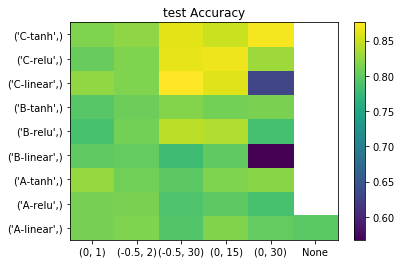

In [12]:
#plt.figure(figsize=(8,3))

plt.pcolor(r_test)
plt.yticks(np.arange(0.5, len(r_test.index), 1), r_test.index)
plt.xticks(np.arange(0.5, len(r_test.columns), 1), r_test.columns)
plt.title('test Accuracy')
plt.colorbar()
plt.show()

### Build the bar plots

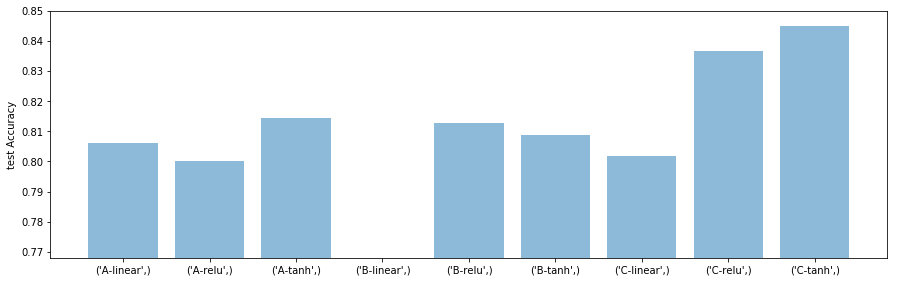

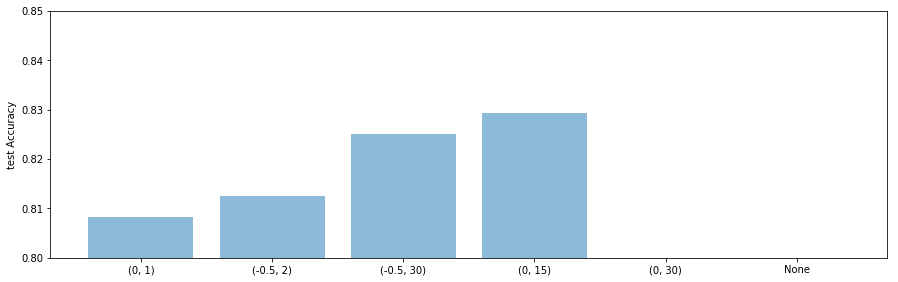

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.bar(np.arange(np.shape(r_test)[0]), r_test.mean(axis=1), align='center', alpha=0.5)
plt.xticks(np.arange(np.shape(r_test)[0]), r_test.index)
plt.ylim((0.768, 0.85))
plt.ylabel('test Accuracy')
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(212)
plt.bar(np.arange(np.shape(r_test)[1]), r_test.mean(axis=0), align='center', alpha=0.5)
plt.xticks(np.arange(np.shape(r_test)[1]), r_test.columns)
plt.ylim((0.8, 0.85))
plt.ylabel('test Accuracy')
plt.show()
